In [2]:
import tsai.all
import datetime
import pandas as pd
import torch
import numpy as np
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import time
import math

In [3]:
%run ../../shared_functions.py
%run ../../my_shared_functions.py

<Figure size 640x480 with 0 Axes>

In [4]:
DIR_INPUT = '../../../fraud-detection-handbook/simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 578 ms
Wall time: 572 ms
919767 transactions loaded, containing 8195 fraudulent transactions


### Default

In [5]:
BEGIN_DATE = "2018-08-08"
start_date_training = datetime.datetime.strptime(BEGIN_DATE, "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

SEQ_LEN = 5

In [7]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

seed_everything(SEED)

Selected device is cuda


In [8]:
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)
x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
X, y, splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])

#### Fit 1 cycle

In [9]:
config = dict(
    dataset_id = 'fraud-detection-handbook-transformed',
    validation = 'train test split',
    seed = SEED,
    begin_date = BEGIN_DATE,
    delta_train = delta_train,
    delta_delay = delta_delay,
    delta_test = delta_test,
    batch_size=64,
    num_workers=0,
    seq_len=SEQ_LEN,
    d_model=128,
    depth=6,
    n_heads=16,
    act='gelu',
    lsa=False,
    attn_dropout=0,
    dropout=0,
    drop_path_rate=0,
    mlp_ratio=1,
    qkv_bias=True,
    pre_norm=False,
    use_token=False, # use_token set to False as c_out == 1
    use_pe=True,
    cat_pos=None,
    n_cat_embeds=None,
    cat_embed_dims=None,
    cat_padding_idxs=None,
    token_size=None,
    tokenizer=None,
    feature_extractor=None,
    flatten=False,
    concat_pool=True,
    fc_dropout=0,
    use_bn=False,
    bias_init=None,
    y_range=None,
    custom_head=None,
    optimizer='adam',
    early_stopping=True,
    early_stopping_patience=2,
    max_epochs=100,
    scale=True,
    criterion='bce',
    one_cycle_policy=True
)
wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['tsit', 'transformer', 'tsai', 'imbalance-not-considered'])
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chamera (mgr-anomaly-tsxai). Use `wandb login --relogin` to force relogin


In [10]:
dsets = tsai.all.TSDatasets(X, y, splits=splits, inplace=True)
dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, drop_last=False, device=DEVICE)
model = tsai.all.TSiT(
    c_in=dls.vars,
    c_out=dls.c,
    seq_len=SEQ_LEN,
    d_model=config.d_model,
    depth=config.depth,
    n_heads=config.n_heads,
    act=config.act,
    lsa=config.lsa,
    attn_dropout=config.attn_dropout,
    dropout=config.dropout,
    drop_path_rate=config.drop_path_rate,
    mlp_ratio=config.mlp_ratio,
    qkv_bias=config.qkv_bias,
    pre_norm=config.pre_norm,
    use_token=config.use_token,
    use_pe=config.use_pe,
    cat_pos=config.cat_pos,
    n_cat_embeds=config.n_cat_embeds,
    cat_embed_dims=config.cat_embed_dims,
    cat_padding_idxs=config.cat_padding_idxs,
    token_size=config.token_size,
    tokenizer=config.tokenizer,
    feature_extractor=config.feature_extractor,
    flatten=config.flatten,
    concat_pool=config.concat_pool,
    fc_dropout=config.fc_dropout,
    use_bn=config.use_bn,
    bias_init=config.bias_init,
    y_range=config.y_range,
    custom_head=config.custom_head
)

In [11]:
criterion = tsai.all.BCEWithLogitsLossFlat()
learn = tsai.all.ts_learner(
    dls,
    model,
    loss_func=criterion,
    opt_func=tsai.all.Adam,
    device=DEVICE,
    metrics=[],
    model_dir='TSiT',
    cbs=[
        WandbCallback(
            log='all',
            log_model=True,
            seed=config.seed),
        EarlyStoppingCallback(
            patience=config.early_stopping_patience
        ),
        SaveModelCallback(
            fname='tsit_fit_one_cycle'
        )])

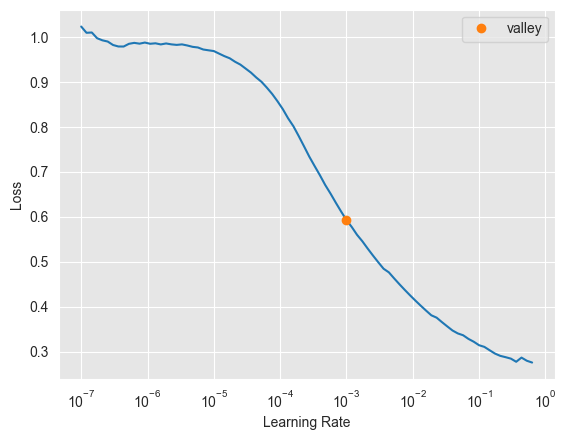

In [12]:
lr = learn.lr_find().valley
wandb.config.update({"lr": lr})

In [13]:
start_time=time.time()
learn.fit_one_cycle(config.max_epochs, lr)
training_execution_time=time.time()-start_time

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


Better model found at epoch 0 with valid_loss value: 0.030184578150510788.
Better model found at epoch 1 with valid_loss value: 0.028662720695137978.
Better model found at epoch 2 with valid_loss value: 0.02729632705450058.
Better model found at epoch 3 with valid_loss value: 0.025884345173835754.
Better model found at epoch 4 with valid_loss value: 0.021282503381371498.
Better model found at epoch 5 with valid_loss value: 0.020052548497915268.
Better model found at epoch 6 with valid_loss value: 0.01932070031762123.
Better model found at epoch 7 with valid_loss value: 0.018474802374839783.
No improvement since epoch 7: early stopping


In [14]:
start_time=time.time()
valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
prediction_execution_time=time.time()-start_time
predictions_df = valid_df
predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
    
performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
performance_df

AUC ROC  Average precision  F1 score  Card Precision@100
0    0.904              0.663     0.667               0.301

In [15]:
wandb.log({'Training execution time': training_execution_time})
wandb.log({'Prediction execution time': prediction_execution_time})
wandb.log({'AUC ROC': performance_df.loc[0,'AUC ROC']})
wandb.log({'Average precision': performance_df.loc[0,'Average precision']})
wandb.log({'F1 score': performance_df.loc[0,'F1 score']})
wandb.log({'Card Precision@100': performance_df.loc[0,'Card Precision@100']})
wandb.finish()

### Sweeps

In [16]:
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
delta_valid = delta_test

n_folds=4

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [17]:
SEED = 42
seed_everything(SEED)

prequential_split = []
        
for fold in range(n_folds):
    start_date_training_fold = start_date_training-datetime.timedelta(days=fold*delta_assessment)
    
    (train_df, test_df)=get_train_test_set(transactions_df,
                                            start_date_training=start_date_training_fold,
                                            delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_assessment)
    
    prequential_split.append((train_df, test_df))

In [18]:
SEQ_LEN = 5
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


#### Fit 1 cycle

In [19]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'goal': 'minimize',
        'name': 'val_loss'
        },
    'parameters': {
        'one_cycle_policy' : {
            'value' : True
        },
        'batch_size': {
            'values' : [64, 128, 256]
        },
        'max_epochs': {
            'values': [2, 3, 4, 5, 6, 7, 8, 9, 10]
        },
        'num_workers': {
            'value' : 0
        },
        'seed': {
            'value' : 42
        },
        'd_model' : { #  total dimension of the model (number of features created by the model)
            'values' : [128, 256, 64, 32, 16]
        },
        'depth' : { #  number of blocks in the encoder
            'values' : [6, 5, 4, 3, 2, 1]
        },
        'n_heads' : { # parallel attention heads. Default:16 (range(8-16))
            'values' : [16, 8, 4]
        },
        'act' : { # the activation function of positionwise feedforward layer
            'value' : 'gelu'
        },
        'lsa' : { # locality self attention used 
            'values' : [False, True]
        },
        'attn_dropout' : { # dropout rate applied to the attention sublayer
            'values' : [0, 0.1, 0.2, 0.3]
        },
        'dropout' : { # dropout applied to to the embedded sequence steps after position embeddings have
                    # been added and to the mlp sublayer in the encoder
            'values' : [0, 0.1, 0.2, 0.3],
        },
        'drop_path_rate' : { # stochastic depth rate
            'value' : 0
        },
        'mlp_ratio' : { # ratio of mlp hidden dim to embedding dim
            'value' : 1
        },
        'qkv_bias' : { # determines whether bias is applied to the Linear projections of queries,
                    # keys and values in the MultiheadAttention
            'value' : True
        },
        'pre_norm' : { # if True normalization will be applied as the first step in the sublayers
            'values' : [False, True]
        },
        'use_token' : { # if True, the output will come from the transformed token. This is meant to
                        # be use in classification tasks
                        #
                        # use_token set to False as c_out == 1
            'value' : False
        },
        'use_pe' : { # flag to indicate if positional embedding is used
            'value' : True
        },
        'cat_pos' : { # list with the position of the categorical variables in the input
            'value' : None
        },
        'n_cat_embeds' : { # list with the sizes of the dictionaries of embeddings (int)
            'value' : None
        },
        'cat_embed_dims' : { # list with the sizes of each embedding vector (int)
            'value' : None
        },
        'cat_padding_idxs' : { # If specified, the entries at cat_padding_idxs do not contribute to the
                                # gradient; therefore, the embedding vector at cat_padding_idxs are not updated
                                # during training. Use 0 for those categorical embeddings that may have #na# values.
                                # Otherwise, leave them as None. You can enter a combination for different
                                # embeddings (for example, [0, None, None])
            'value' : None
        }, 
        'token_size' : { # Size of the embedding function used to reduce the sequence length (similar to ViT’s patch size) 
            'value' : None
        },
        'tokenizer' : { # nn.Module or callable that will be used to reduce the sequence length
            'value' : None
        },
        'feature_extractor' : { # nn.Module or callable that will be used to preprocess the time series before the
                                # embedding step. It is useful to extract features or resample the time series
            'value' : None
        },
        'flatten' : { # flag to indicate if the 3d logits will be flattened to 2d in the model’s head if use_token is set
                    # to False. If use_token is False and flatten is False, the model will apply a pooling layer
            'value' : False
        },
        'concat_pool' : { # if True the head begins with fastai’s AdaptiveConcatPool2d if concat_pool=True; otherwise,
                        # it uses traditional average pooling
            'values' : [True, False]
        },
        'fc_dropout' : { # dropout applied to the final fully connected layer
            'values' : [0, 0.1, 0.2, 0.3]
        },
        'use_bn' : { # flag that indicates if batchnorm will be applied to the head
            'values' : [False, True]
        },
        'bias_init' : { # values used to initialized the output layer
            'value' : None
        },
        'y_range' : { # ange of possible y values (used in regression tasks)
            'value' : None
        },
        'custom_head' : {
            'value' : None
        }
    }
}

In [22]:
sweep_id = wandb.sweep(sweep_config, project="mgr-anomaly-tsxai-project")

Create sweep with ID: gllqr5np
Sweep URL: https://wandb.ai/mgr-anomaly-tsxai/mgr-anomaly-tsxai-project/sweeps/gllqr5np


In [20]:
def train(config=None):
    with wandb.init(project="mgr-anomaly-tsxai-project", config=config, tags=['tsit', 'transformer', 'tsai', 'imbalance-not-considered', 'sweeps']):
        config = wandb.config
        training_execution_times = []
        prediction_execution_times = []
        aucs = []
        average_precisions = []
        f1_scores = []
        card_precisions = []
        for i in range(n_folds):
            train_df = prequential_split[i][0]
            valid_df = prequential_split[i][1]
            (train_df, valid_df)=scaleData(train_df, valid_df,input_features)
            x_train, y_train = prepare_sequenced_X_y(train_df, SEQ_LEN, input_features, output_feature)
            x_valid, y_valid = prepare_sequenced_X_y(valid_df, SEQ_LEN, input_features, output_feature)
            X, y, tsai_splits = tsai.all.combine_split_data([x_train.numpy(), x_valid.numpy()], [y_train.numpy(), y_valid.numpy()])
            dsets = tsai.all.TSDatasets(X, y, splits=tsai_splits, inplace=True)
            dls = tsai.all.TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=config.batch_size, num_workers=config.num_workers, device=DEVICE, drop_last=False)
            
            model = tsai.all.TSiT(
                c_in=dls.vars,
                c_out=dls.c,
                seq_len=SEQ_LEN,
                d_model=config.d_model,
                depth=config.depth,
                n_heads=config.n_heads,
                act=config.act,
                lsa=config.lsa,
                attn_dropout=config.attn_dropout,
                dropout=config.dropout,
                drop_path_rate=config.drop_path_rate,
                mlp_ratio=config.mlp_ratio,
                qkv_bias=config.qkv_bias,
                pre_norm=config.pre_norm,
                use_token=config.use_token,
                use_pe=config.use_pe,
                cat_pos=config.cat_pos,
                n_cat_embeds=config.n_cat_embeds,
                cat_embed_dims=config.cat_embed_dims,
                cat_padding_idxs=config.cat_padding_idxs,
                token_size=config.token_size,
                tokenizer=config.tokenizer,
                feature_extractor=config.feature_extractor,
                flatten=config.flatten,
                concat_pool=config.concat_pool,
                fc_dropout=config.fc_dropout,
                use_bn=config.use_bn,
                bias_init=config.bias_init,
                y_range=config.y_range,
                custom_head=config.custom_head
            )
            
            criterion = tsai.all.BCEWithLogitsLossFlat()
            learn = tsai.all.ts_learner(
                dls,
                model,
                loss_func=criterion,
                opt_func=tsai.all.Adam,
                device=DEVICE,
                metrics=[],
                model_dir='TSiT',
                cbs=[
                    WandbCallback(
                        log=None,
                        log_model=False,
                        seed=config.seed)])

            valley = learn.lr_find().valley

            start_time=time.time()
            learn.fit_one_cycle(config.max_epochs, valley)
            training_execution_times.append(time.time()-start_time)

            start_time=time.time()
            valid_predictions_logits = get_predictions_sequential(learn.model.cuda(), dls.valid)
            prediction_execution_time=time.time()-start_time
            predictions_df = valid_df
            predictions_df['predictions'] = torch.nn.Sigmoid()(torch.FloatTensor(valid_predictions_logits)).numpy()
                
            performance_df = performance_assessment_f1_included(predictions_df, top_k_list=[100])
            aucs.append(performance_df.loc[0,'AUC ROC'])
            average_precisions.append(performance_df.loc[0,'Average precision'])
            f1_scores.append(performance_df.loc[0,'F1 score'])
            card_precisions.append(performance_df.loc[0,'Card Precision@100'])

        wandb.log({'Training execution time': np.sum(training_execution_times) / n_folds})
        wandb.log({'Prediction execution time': np.sum(prediction_execution_times) / n_folds})
        wandb.log({'AUC ROC': np.sum(aucs) / n_folds})
        wandb.log({'Average precision': np.sum(average_precisions) / n_folds})
        wandb.log({'F1 score': np.sum(f1_scores) / n_folds})
        wandb.log({'Card Precision@100': np.sum(card_precisions) / n_folds})

wandb: Agent Starting Run: fb2zj7gr with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: tm147p8k with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running 

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7bgzjv5y with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 4
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: wbevaiki with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: jeuao2v2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 84xplabg with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a04ecmlu with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 43bz41ku with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: zt71ppp4 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 6
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: spftybbh with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: jngg160a with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: adrotesd with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 6
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ytts8k9a with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when r

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: wvjt98wa with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: y9bf7fj7 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: v0ni1757 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 4
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1vb49yq0 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1jezfz15 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 6
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: fmrgdvc0 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 8
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: tjaqonwt with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: axqkymuz with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 41xo2nok with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running 

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: mfd34zyz with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running 

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1gfoaovg with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ar8efsmf with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: k9a11lj2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 5wt6idhy with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 8
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 38xb3oz9 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ur3gfwz2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 1hx1xr52 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 4
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: aygaj569 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: hm16qlp2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: oz2mcm03 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7nqqowti with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: vjrhzrbk with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 6
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when ru

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ktwndmp with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 8
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: epj74yix with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running 

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hxebmpxc with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 4
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code savi

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: o0gzcq2s with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: qao29n16 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 3
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: gwmxi588 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: oh7pjncs with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: ipm6dnle with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when r

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: fyb4w25u with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 6dx7z180 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 3
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ngtxsjz2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 2
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: rohkjwr7 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 8
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: hgqik3mt with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 4
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: y4t0t1k0 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 4
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when r

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 2aww4xdc with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9c6ufu0y with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 6
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wand

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 78za76k0 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.1
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 3pt0jtvb with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lbmbfdte with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 2
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code savin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 6pzepxog with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0
wandb: 	batch_size: 128
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 256
wandb: 	depth: 6
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.3
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: djgbokcp with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.1
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 128
wandb: 	depth: 1
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: True
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runni

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: 7mn5kxtb with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 32
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 5
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: True
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: False
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runnin

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: dzpq73ch with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 64
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: False
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 5
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 7
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when runn

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Agent Starting Run: kawff3kn with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.3
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 16
wandb: 	depth: 6
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.3
wandb: 	fc_dropout: 0.1
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 10
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 4
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when run

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k09zj2i2 with config:
wandb: 	act: gelu
wandb: 	attn_dropout: 0.2
wandb: 	batch_size: 256
wandb: 	bias_init: None
wandb: 	cat_embed_dims: None
wandb: 	cat_padding_idxs: None
wandb: 	cat_pos: None
wandb: 	concat_pool: True
wandb: 	custom_head: None
wandb: 	d_model: 64
wandb: 	depth: 6
wandb: 	drop_path_rate: 0
wandb: 	dropout: 0.2
wandb: 	fc_dropout: 0.2
wandb: 	feature_extractor: None
wandb: 	flatten: False
wandb: 	lsa: False
wandb: 	max_epochs: 9
wandb: 	mlp_ratio: 1
wandb: 	n_cat_embeds: None
wandb: 	n_heads: 16
wandb: 	num_workers: 0
wandb: 	one_cycle_policy: True
wandb: 	pre_norm: False
wandb: 	qkv_bias: True
wandb: 	seed: 42
wandb: 	token_size: None
wandb: 	tokenizer: None
wandb: 	use_bn: True
wandb: 	use_pe: True
wandb: 	use_token: False
wandb: 	y_range: None
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'NoneType' object is not iterable


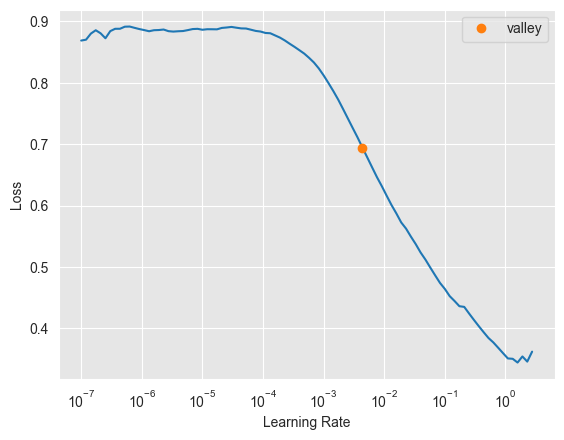

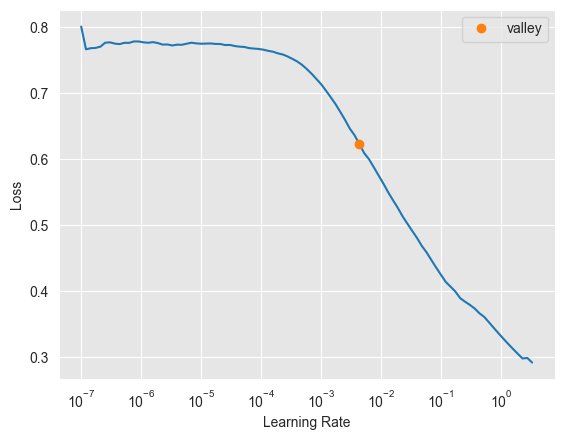

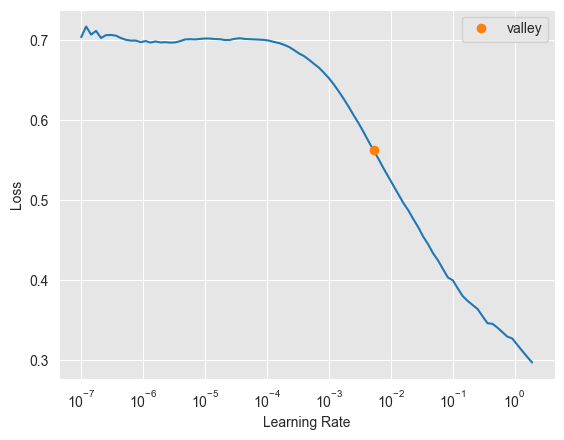

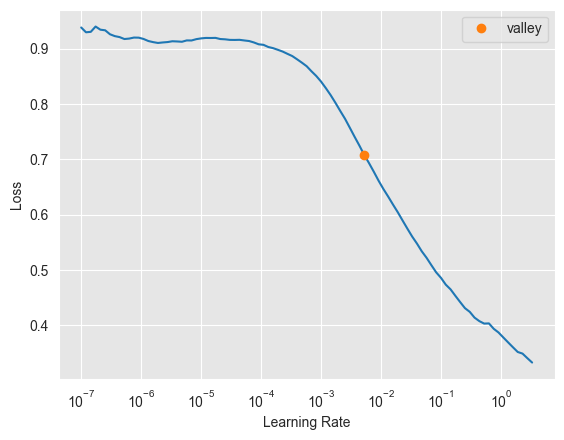

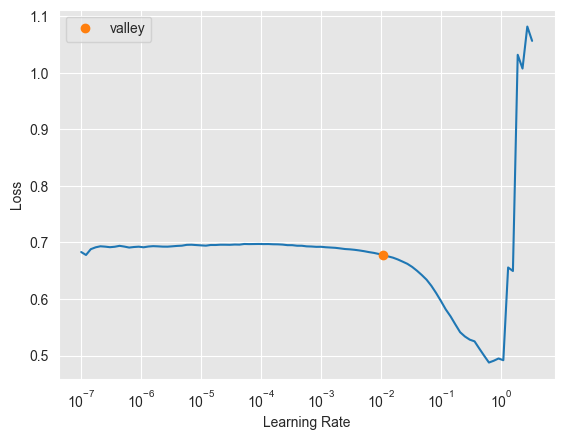

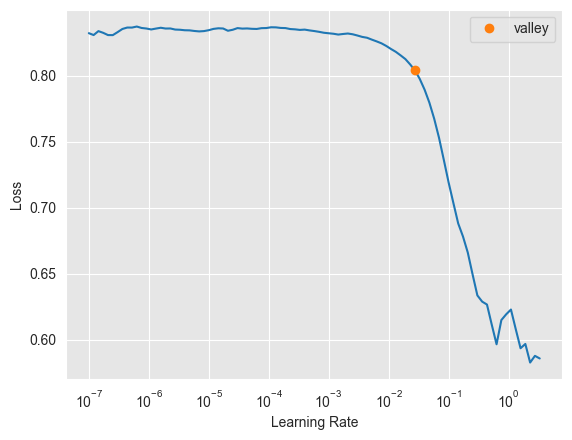

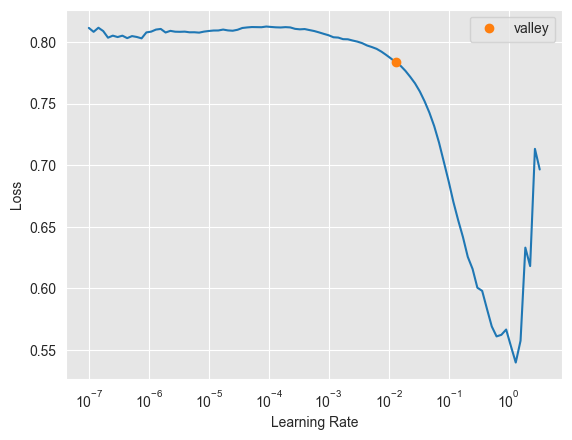

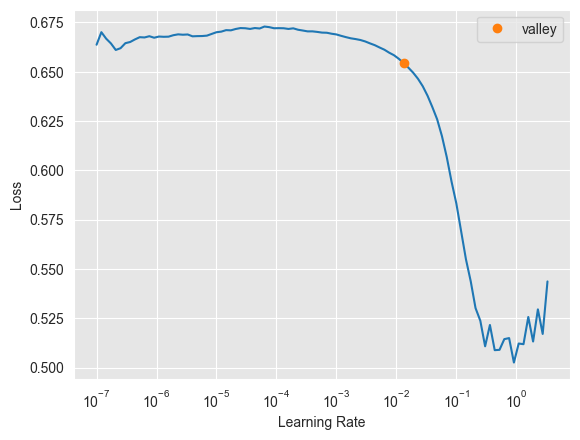

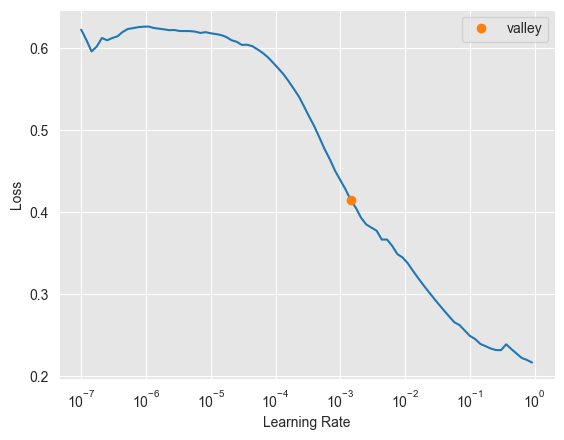

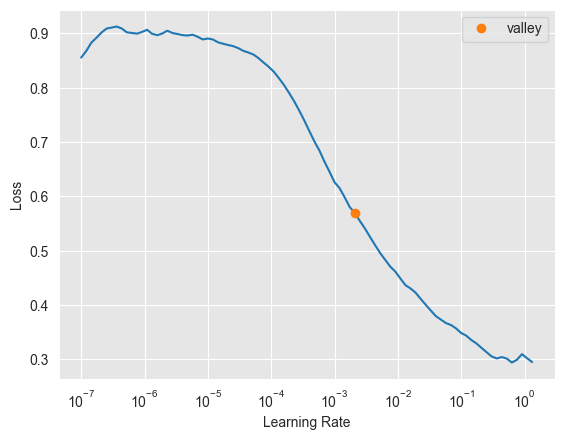

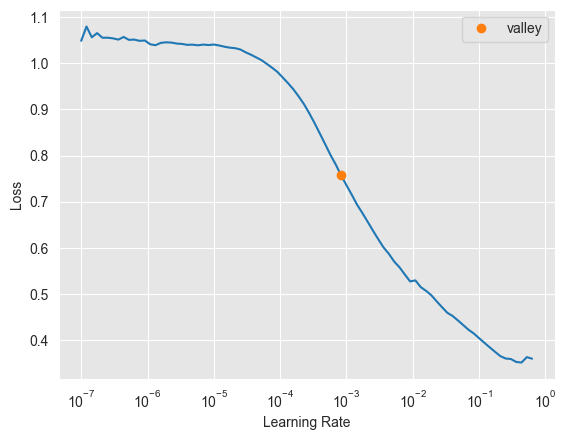

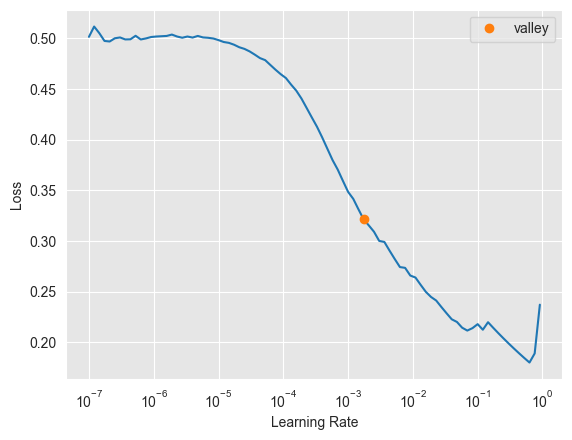

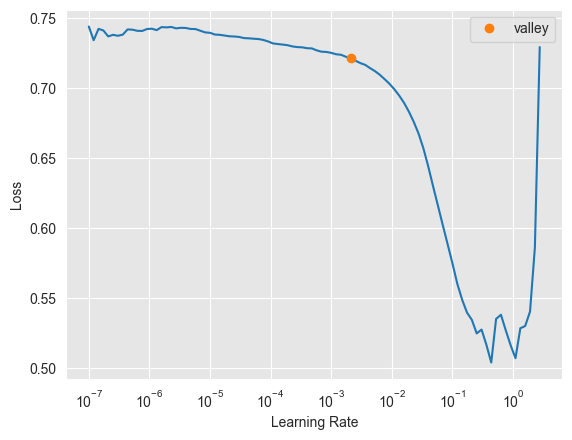

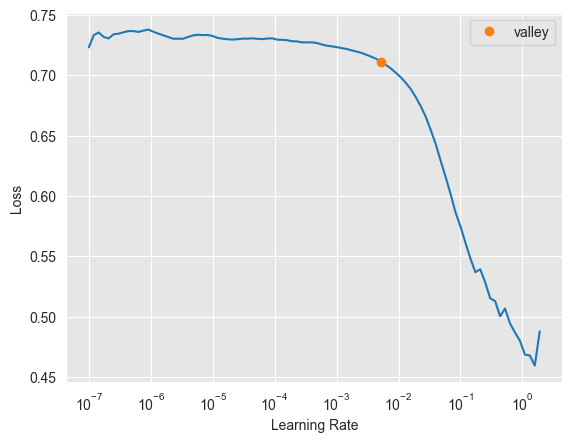

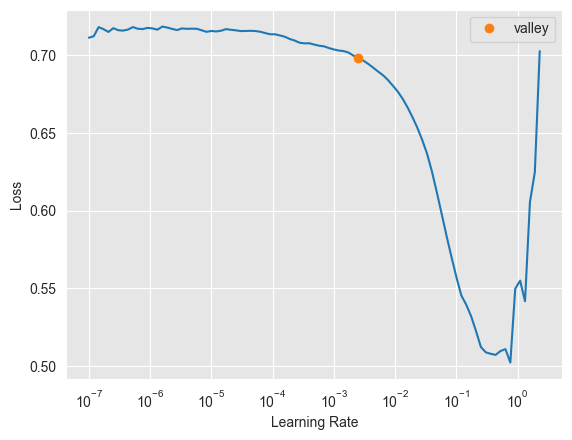

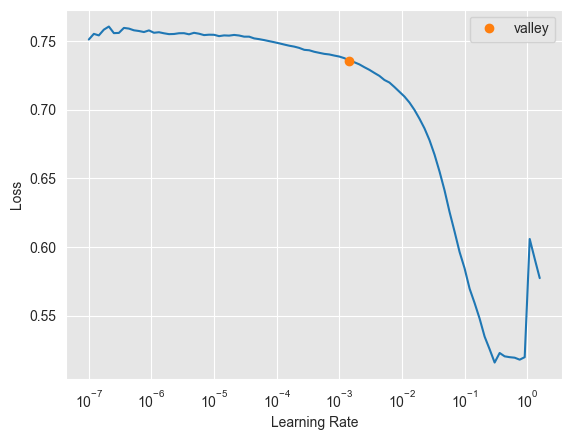

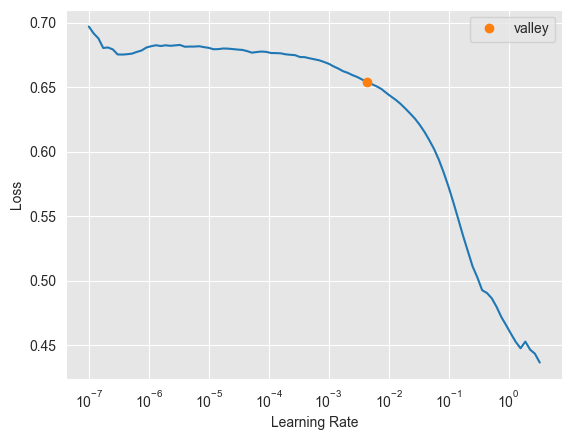

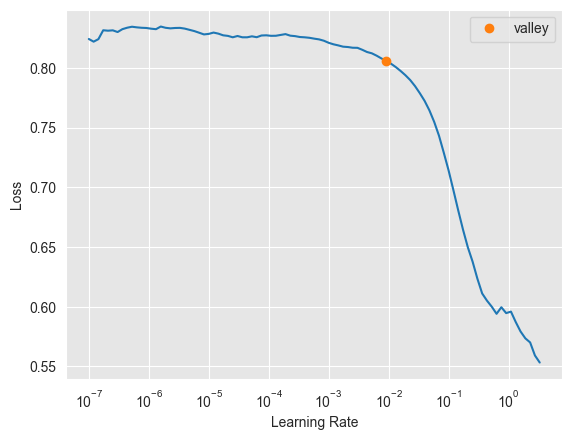

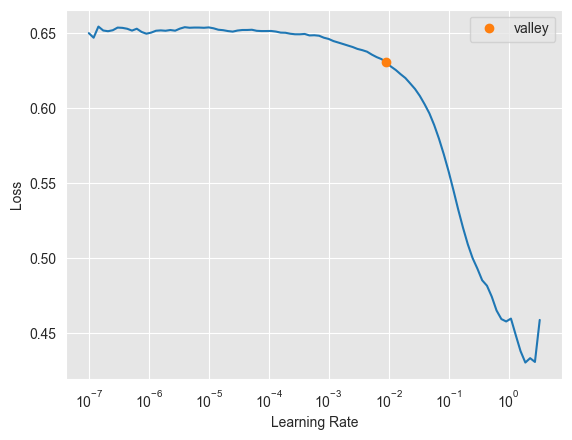

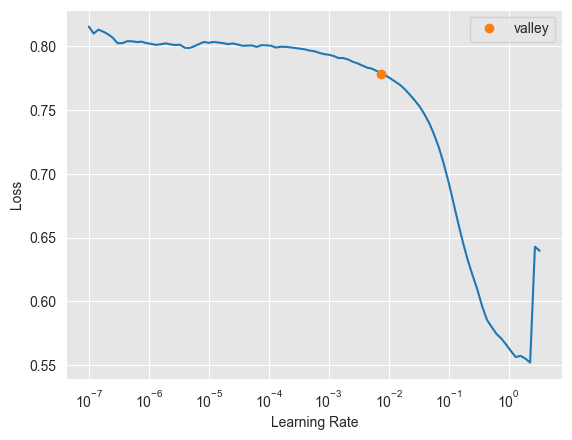

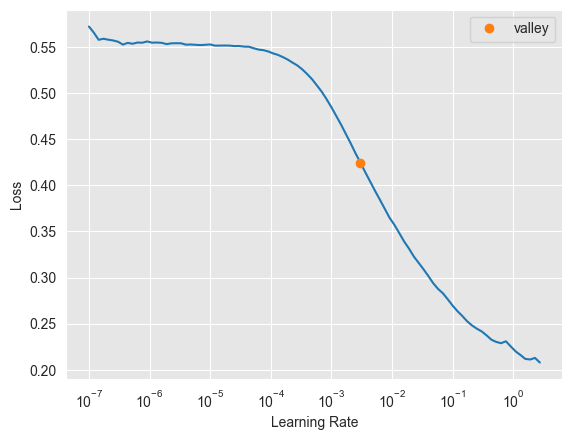

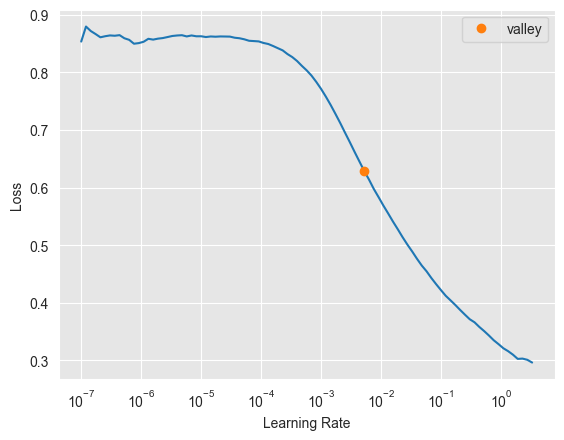

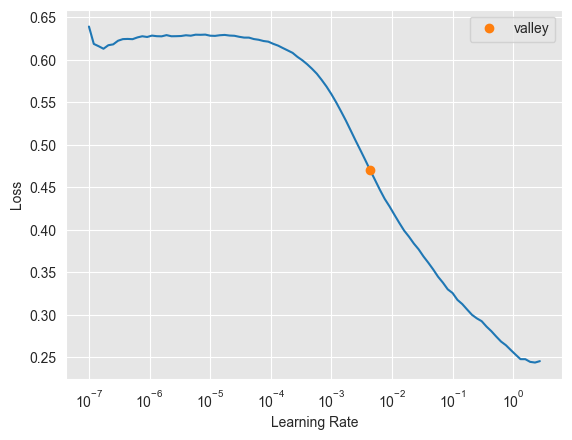

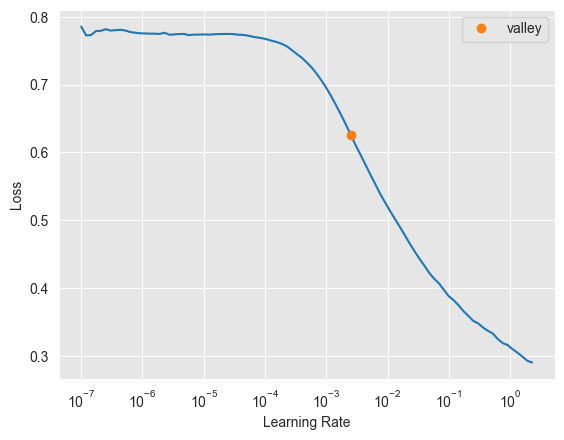

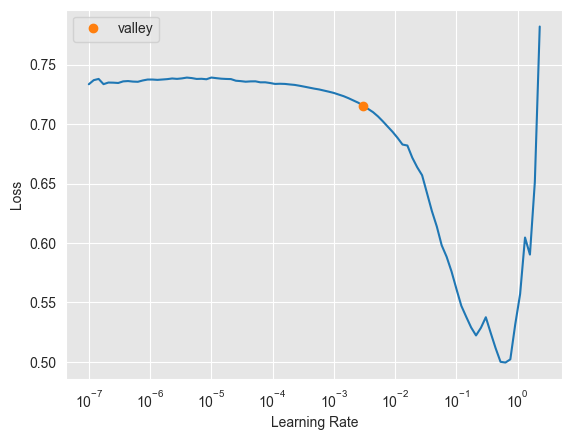

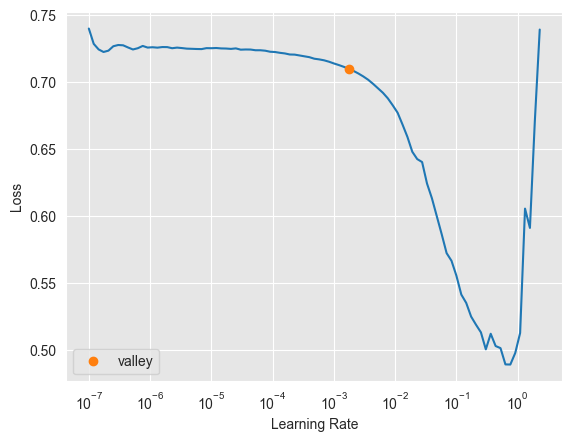

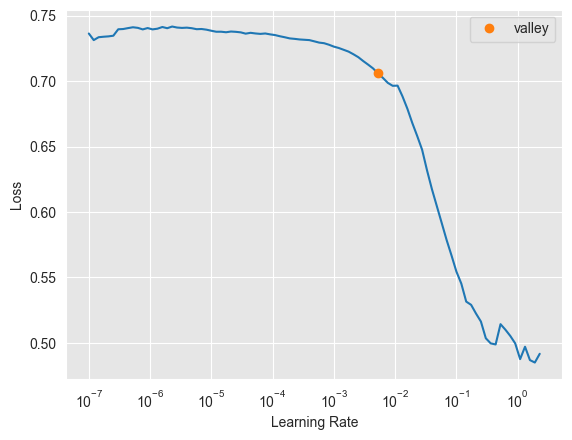

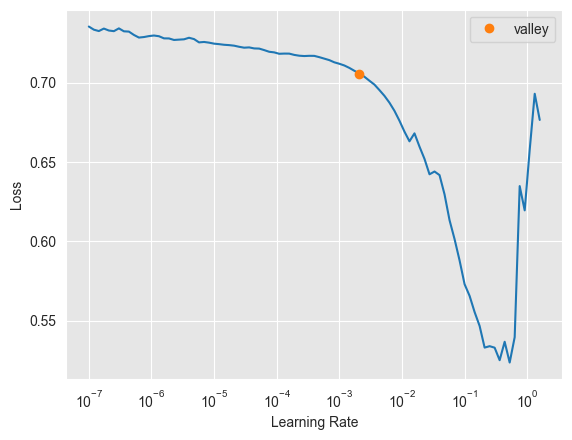

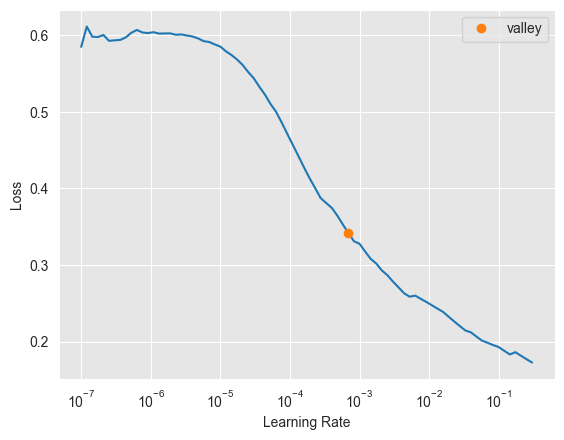

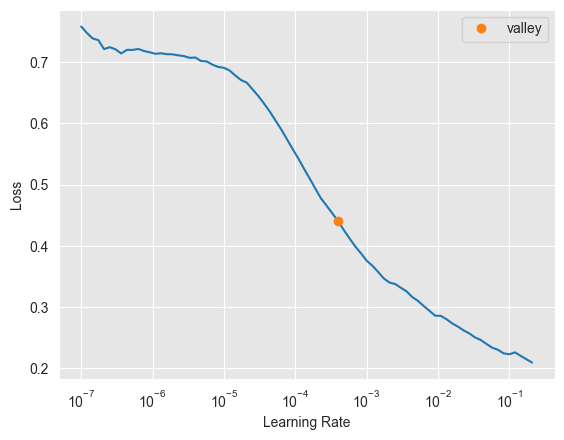

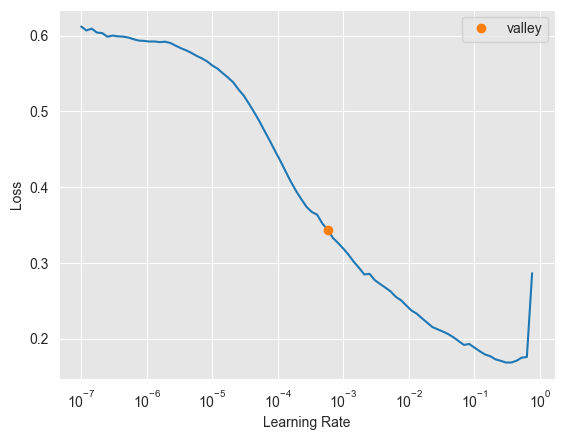

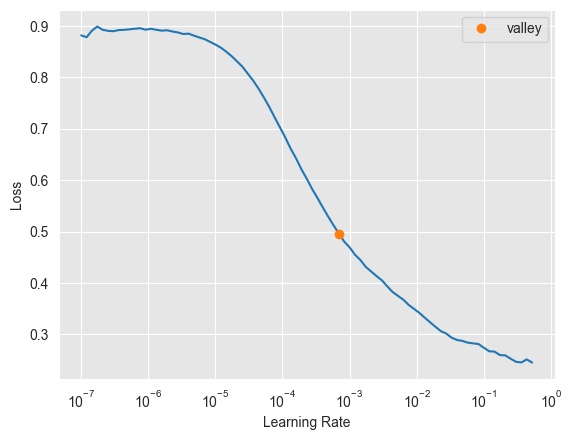

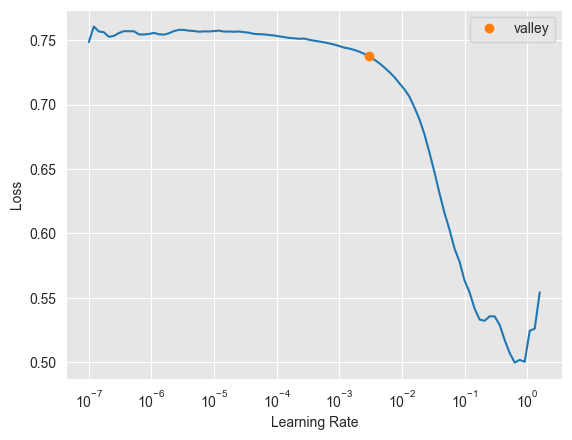

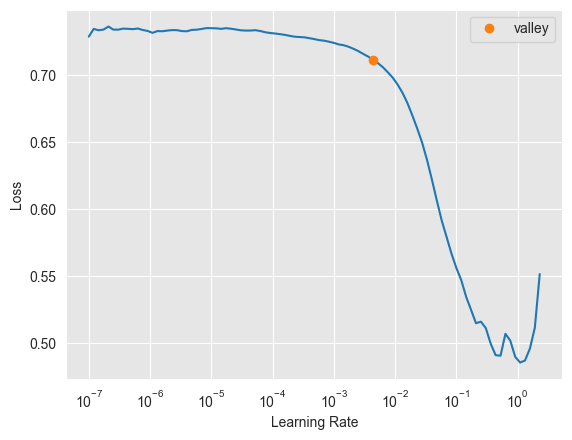

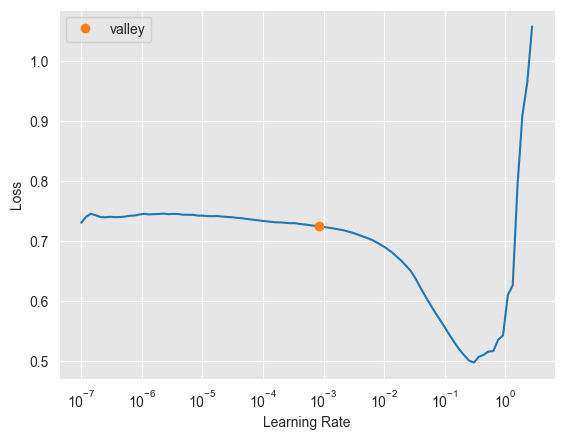

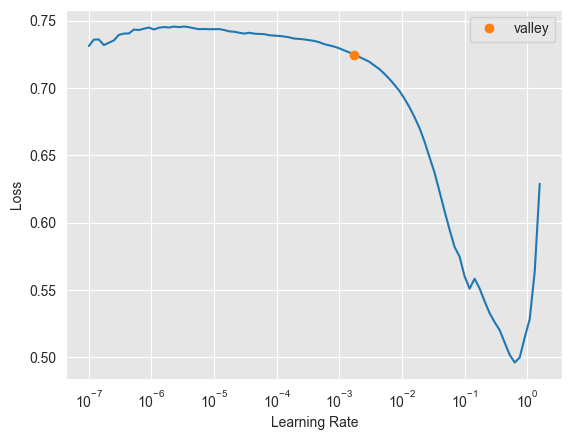

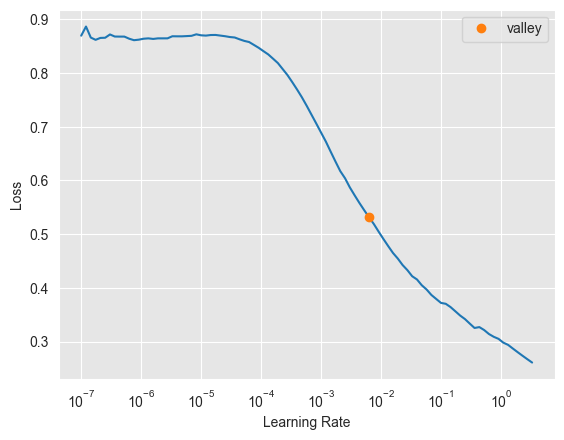

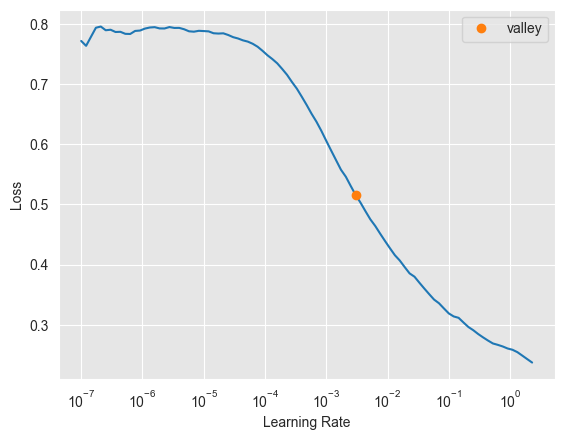

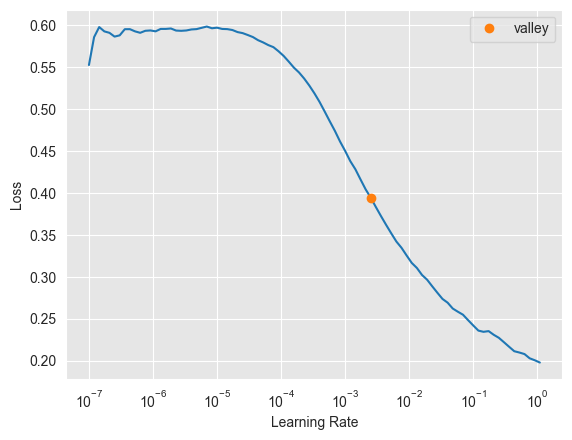

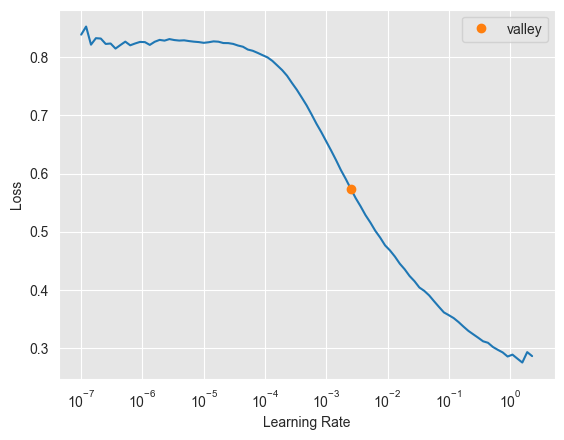

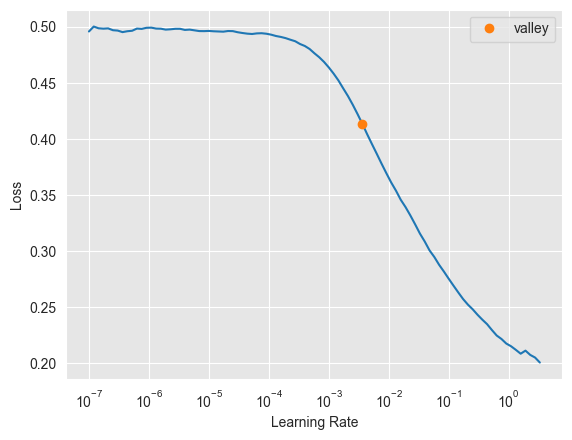

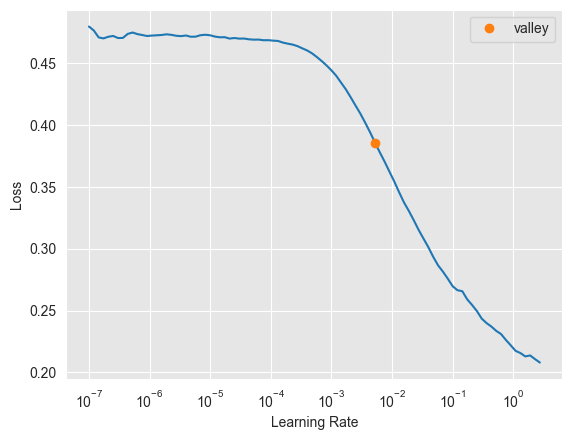

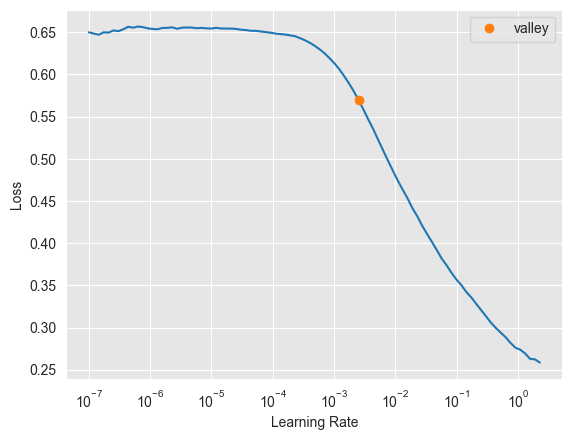

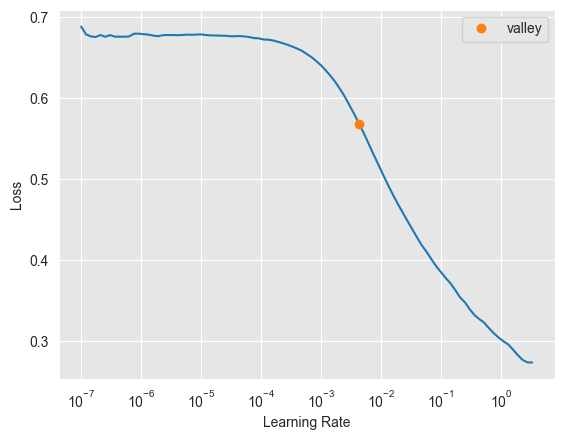

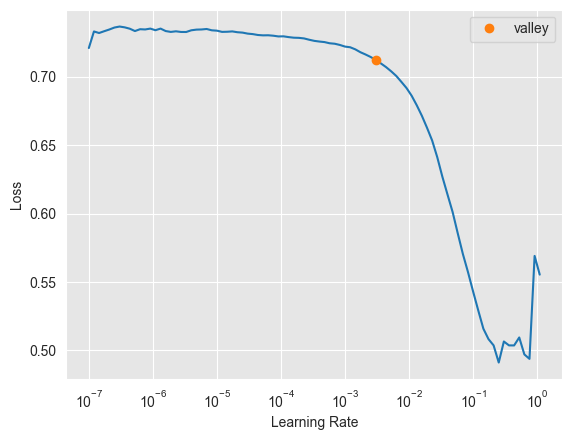

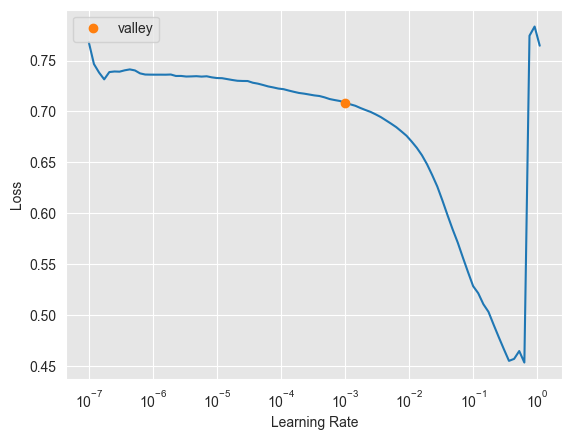

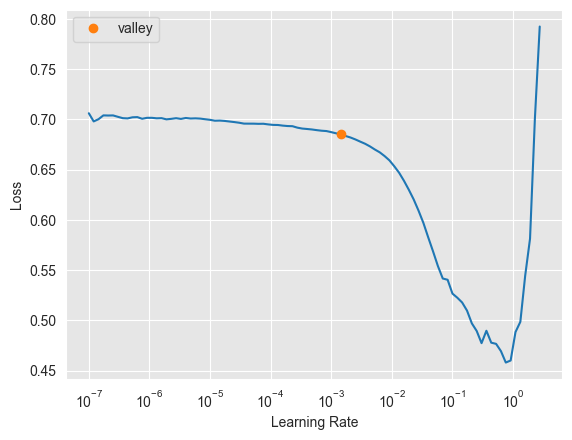

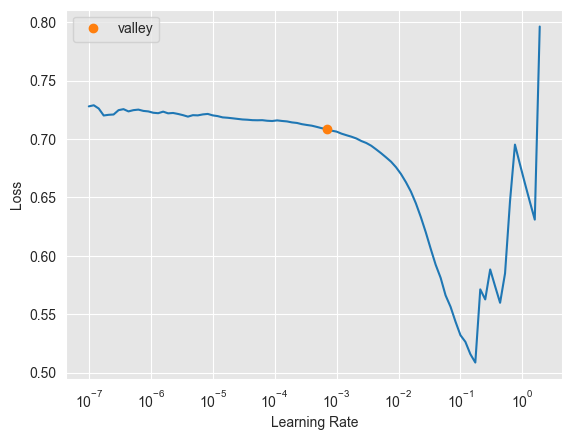

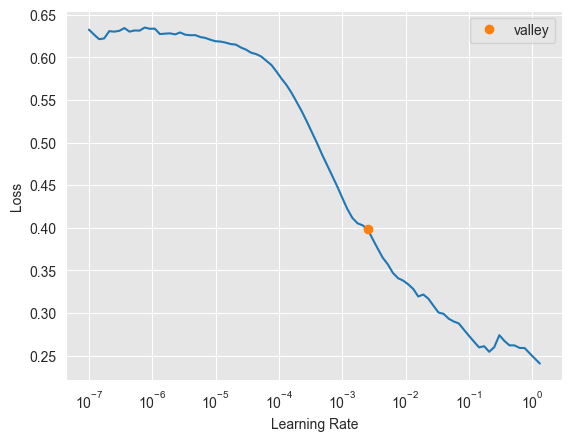

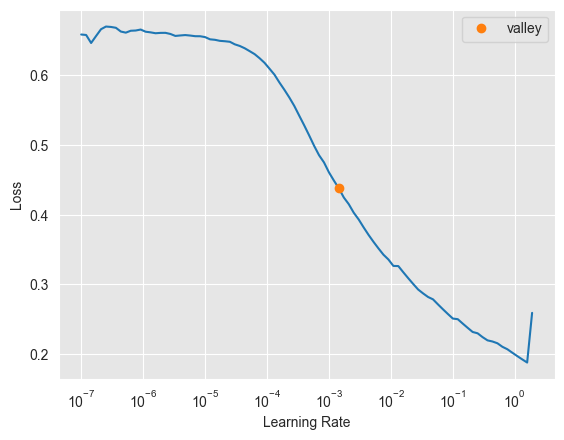

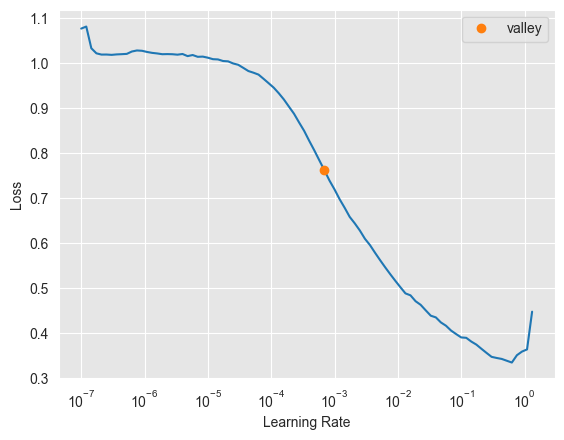

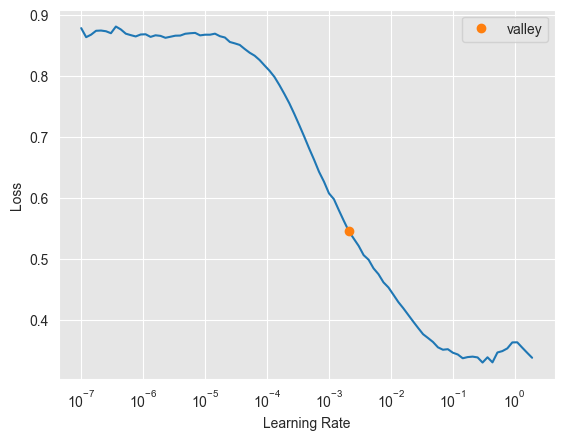

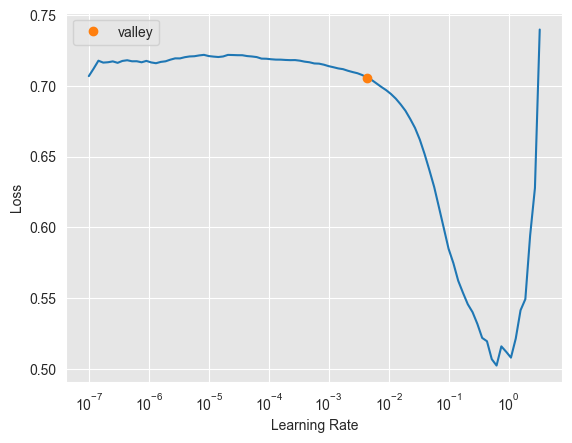

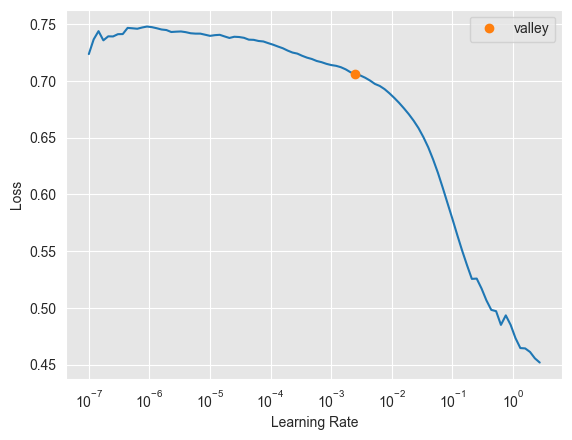

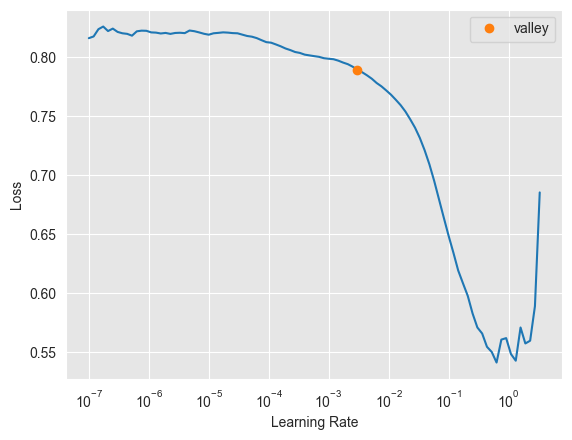

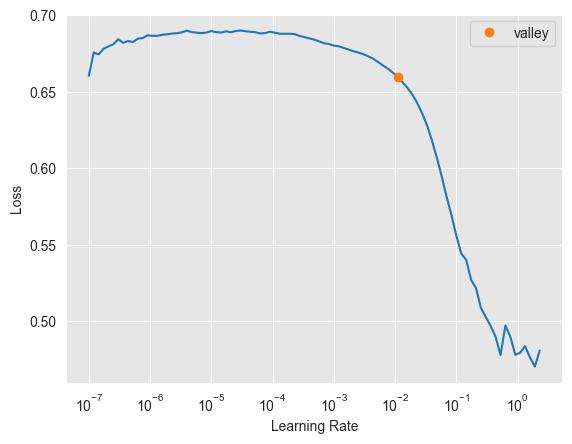

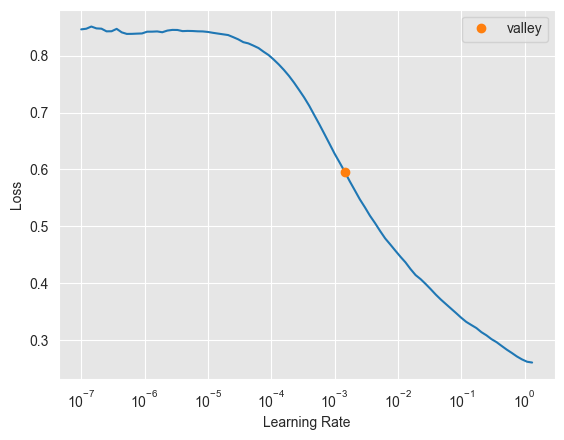

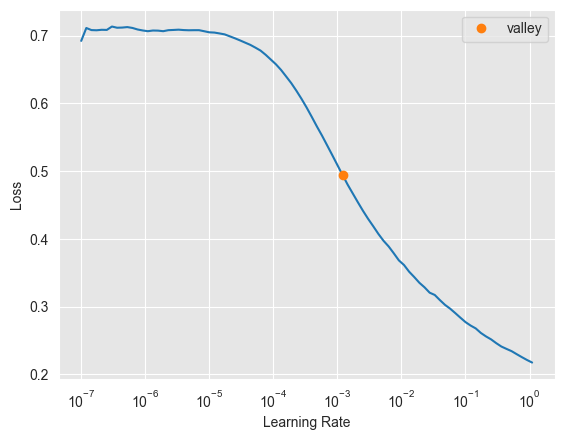

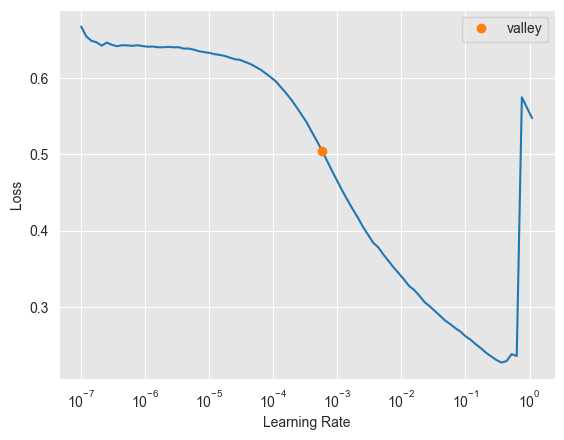

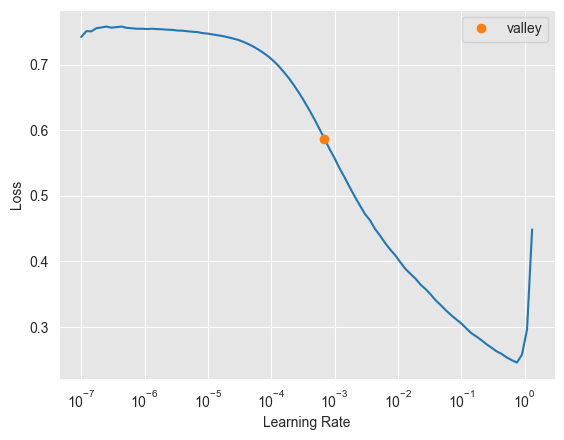

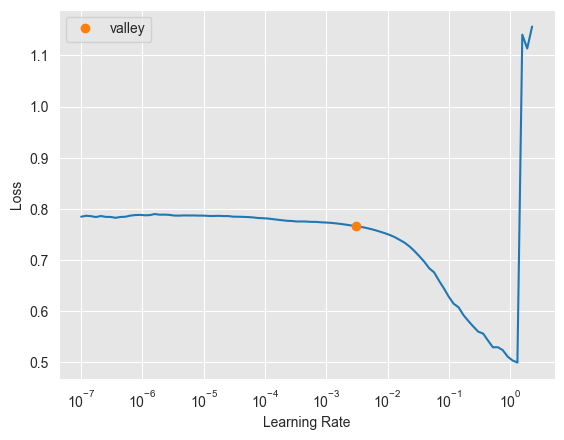

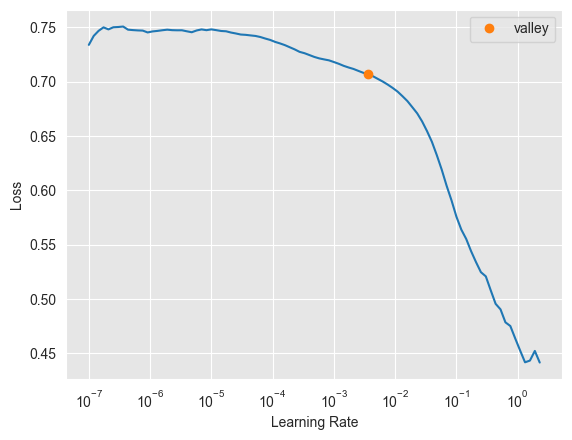

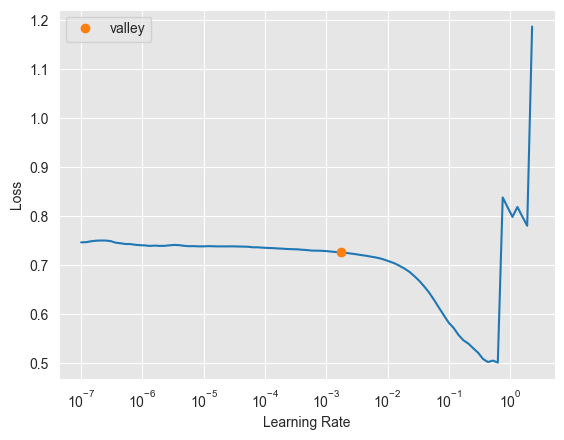

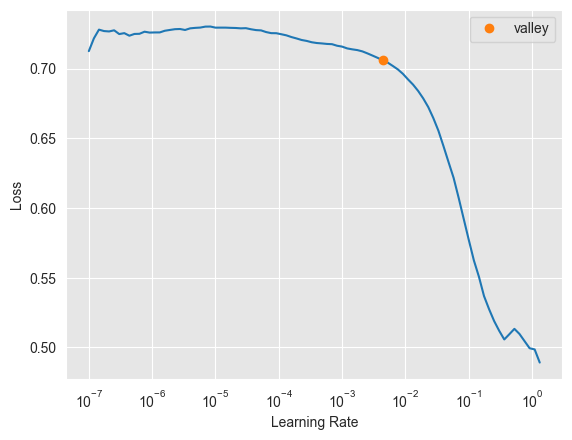

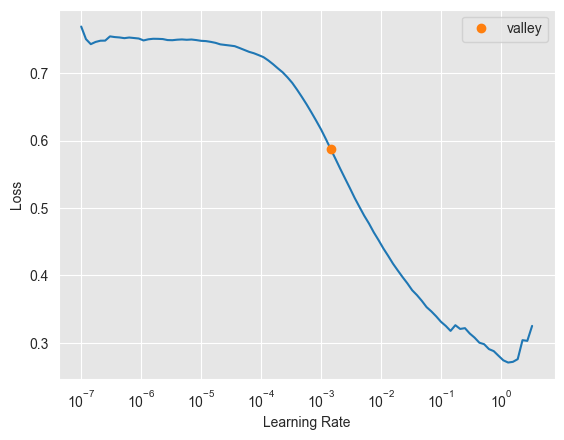

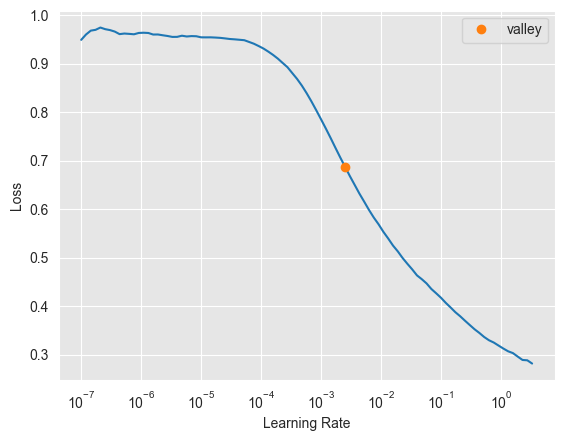

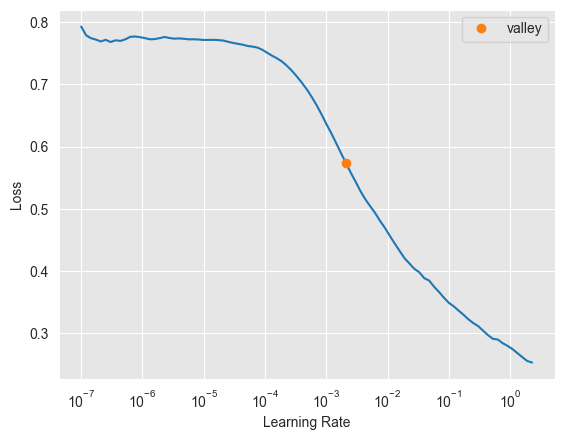

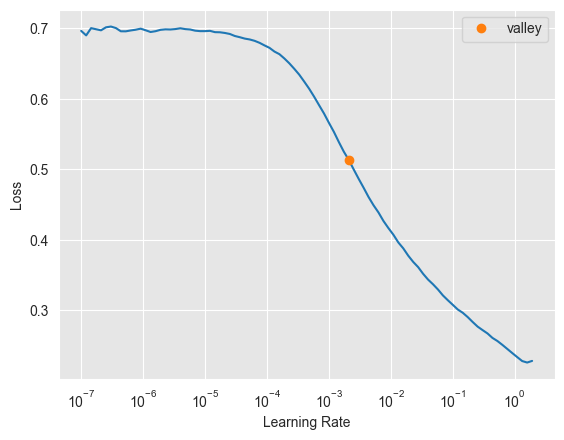

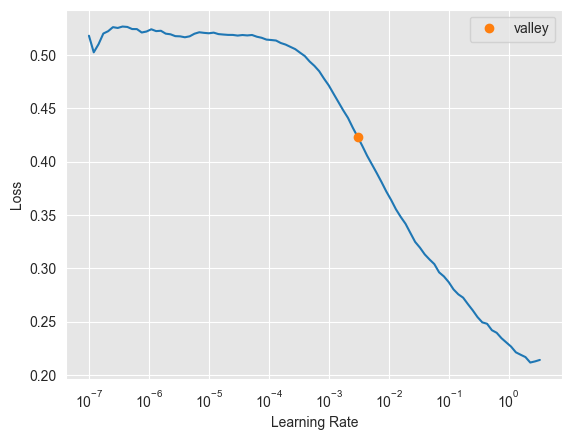

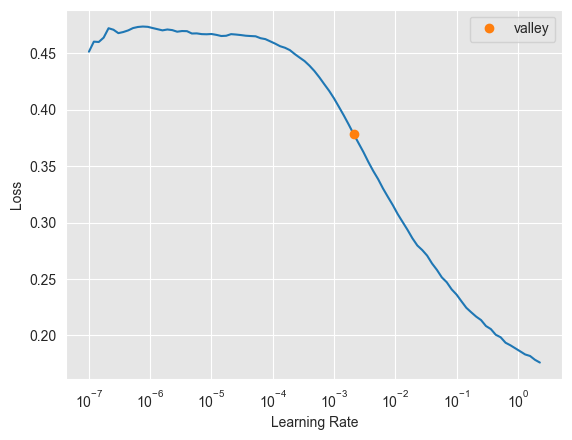

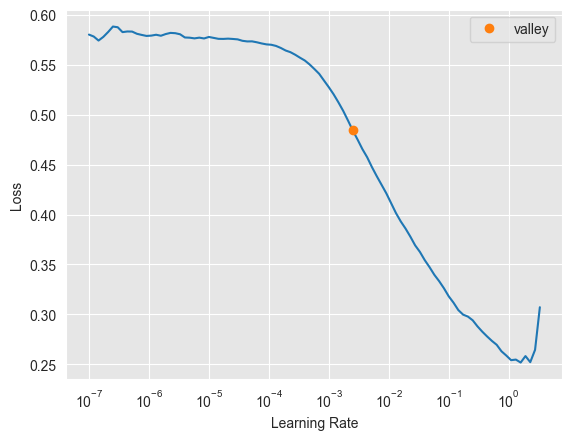

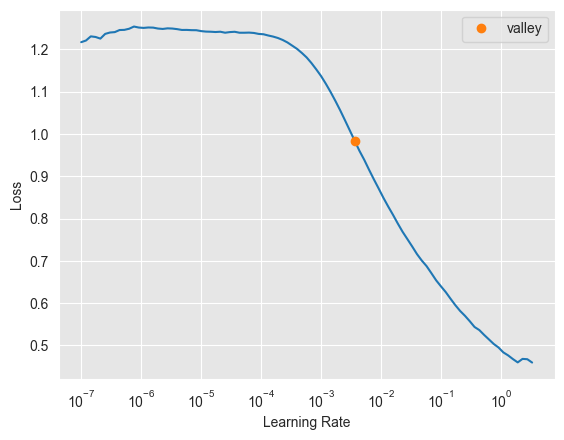

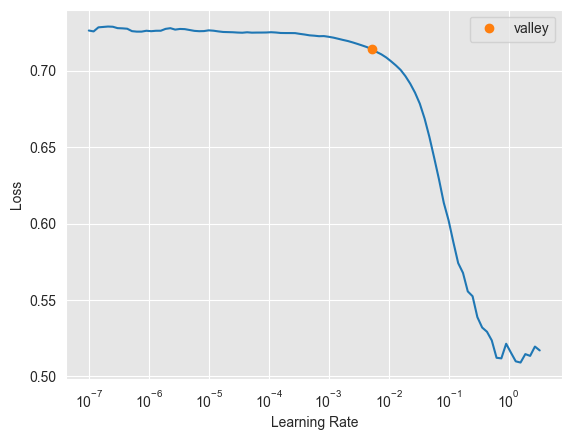

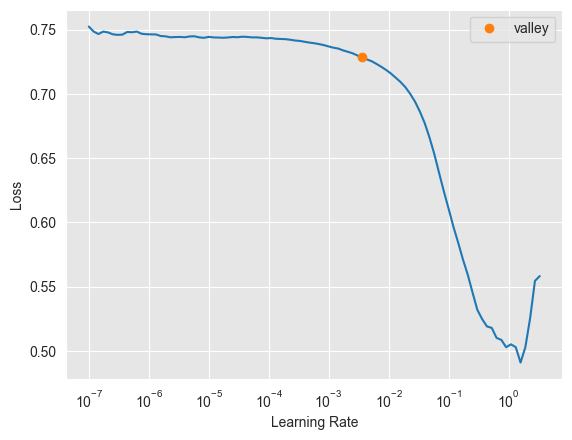

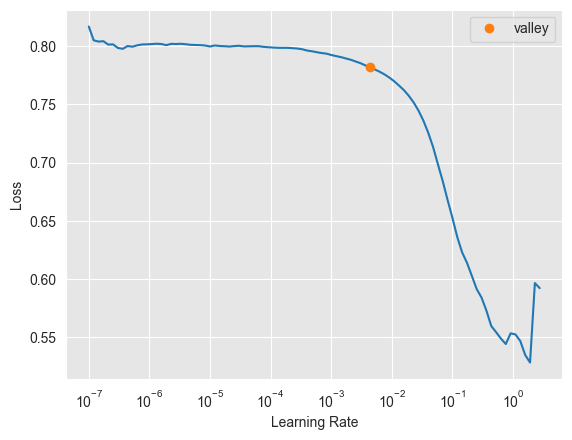

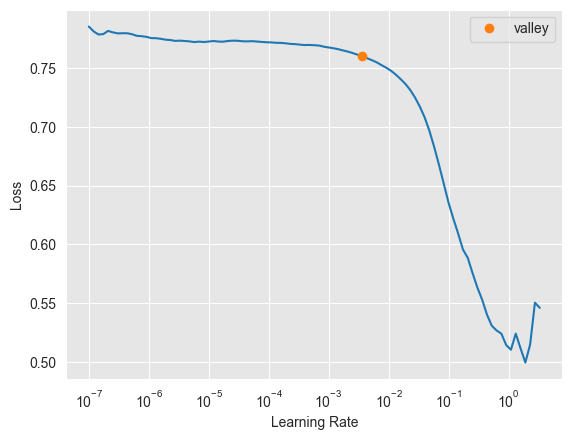

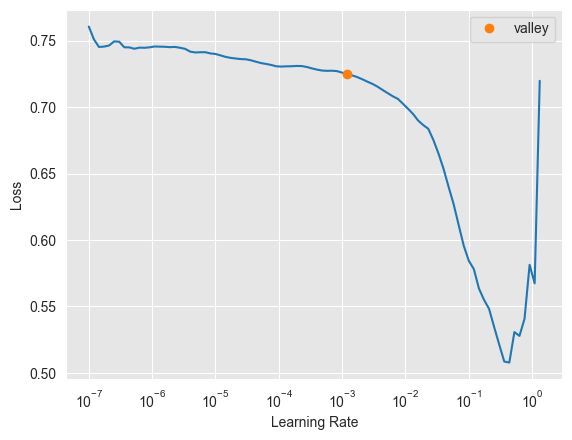

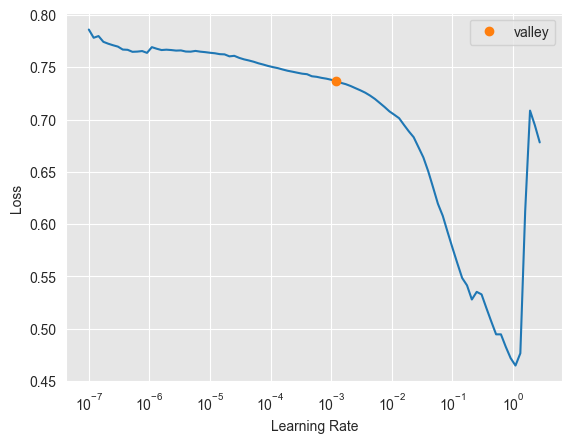

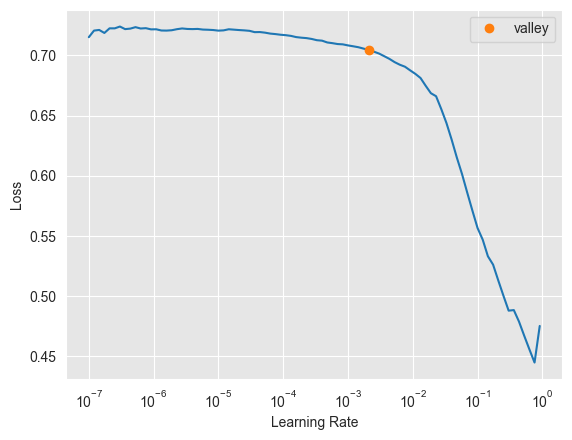

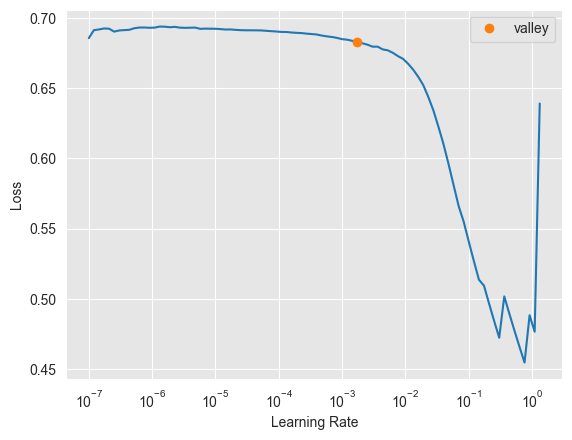

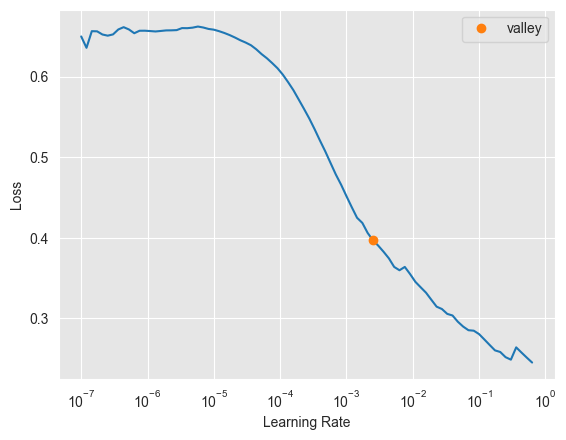

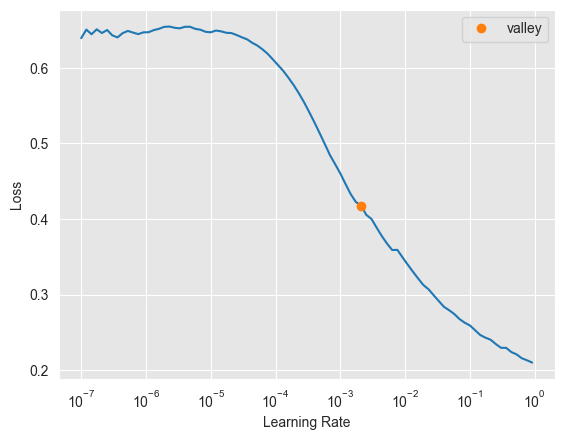

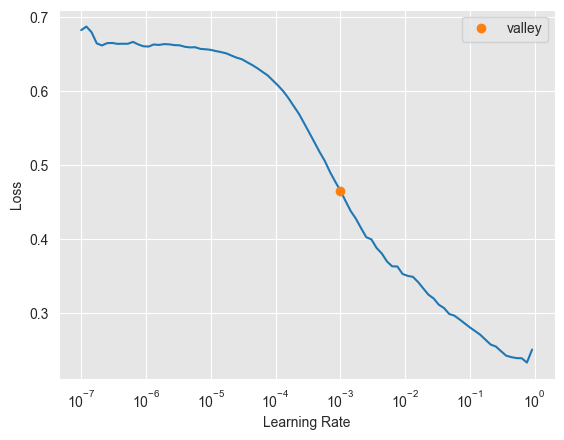

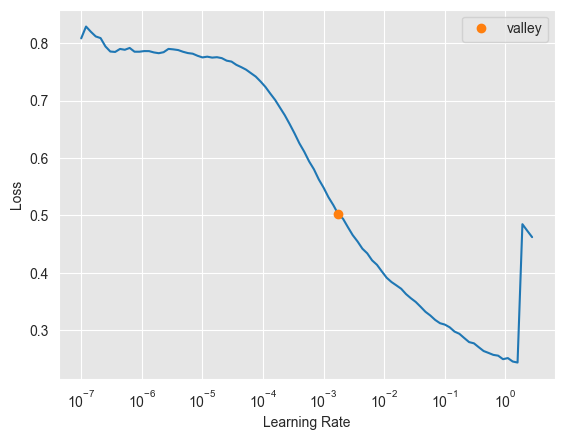

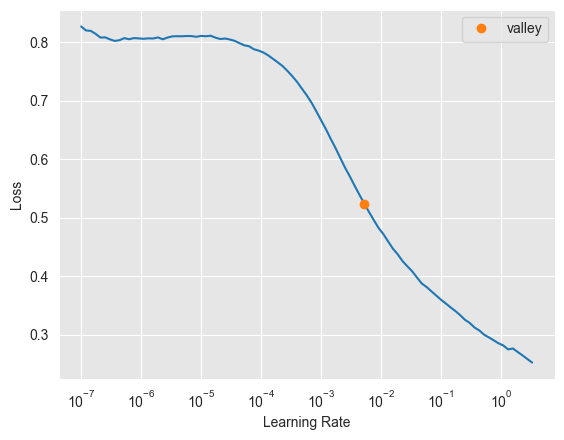

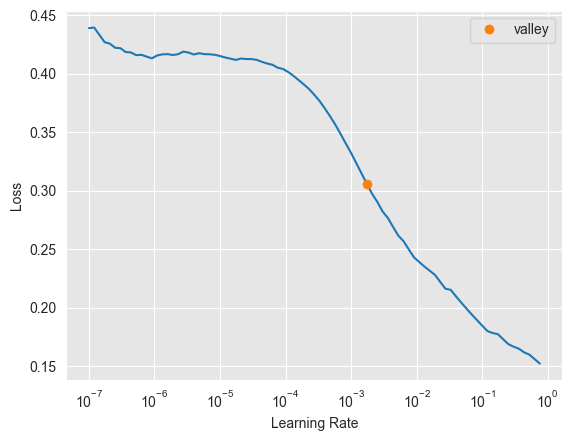

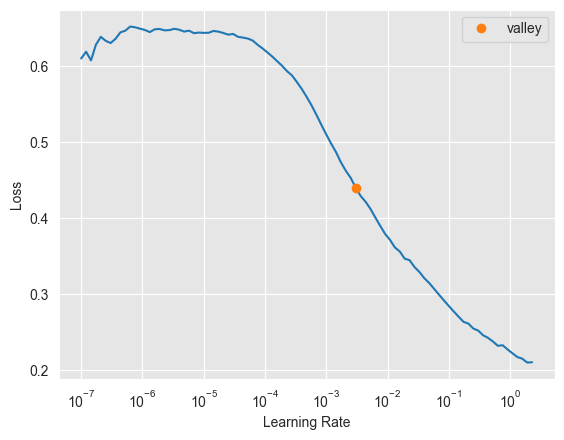

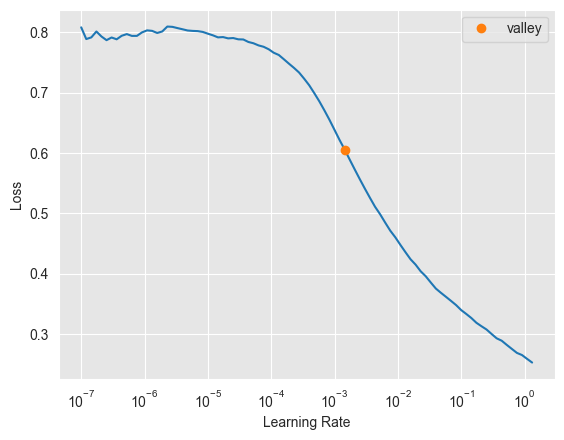

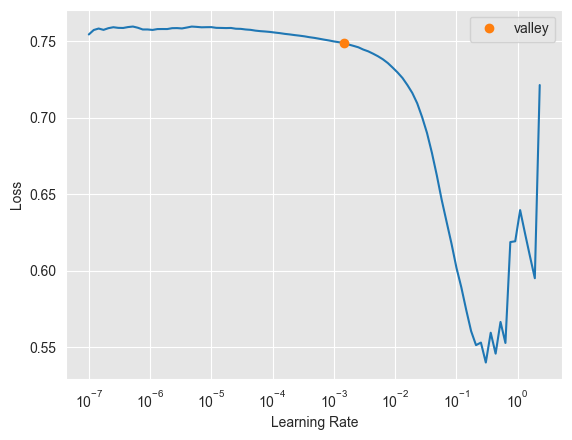

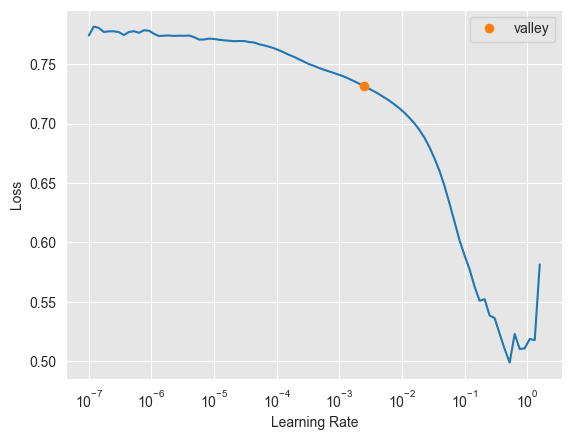

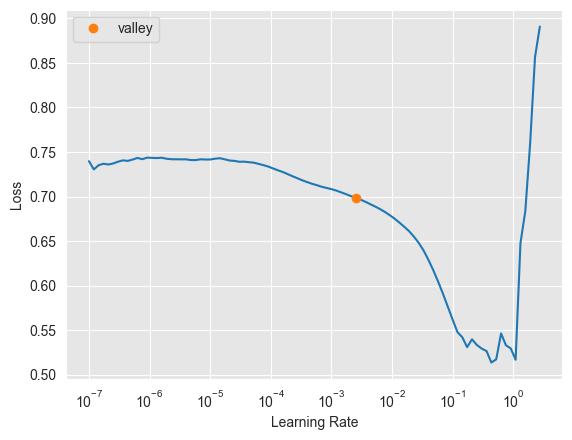

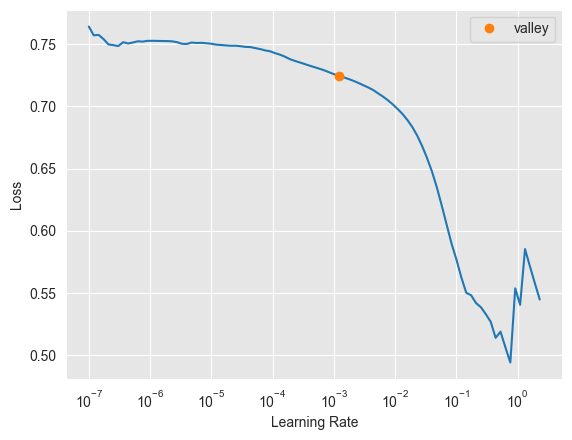

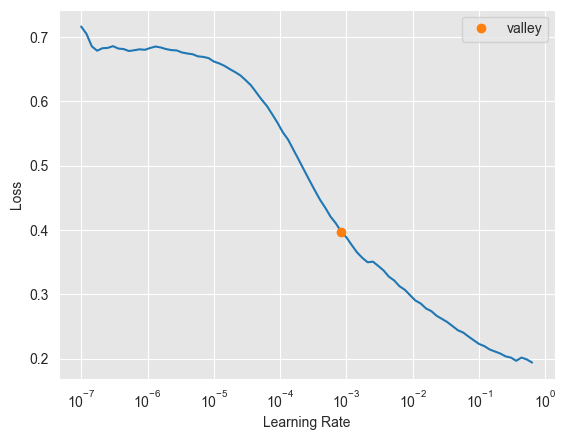

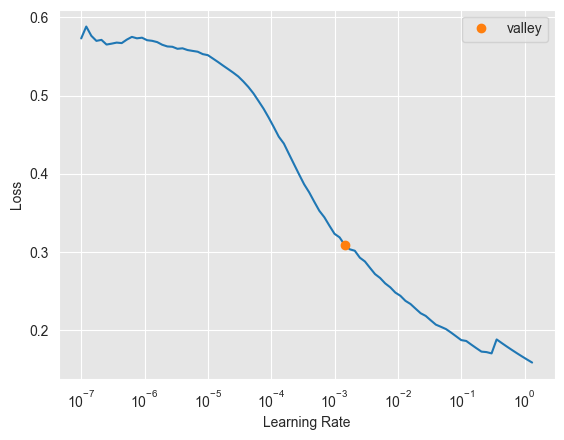

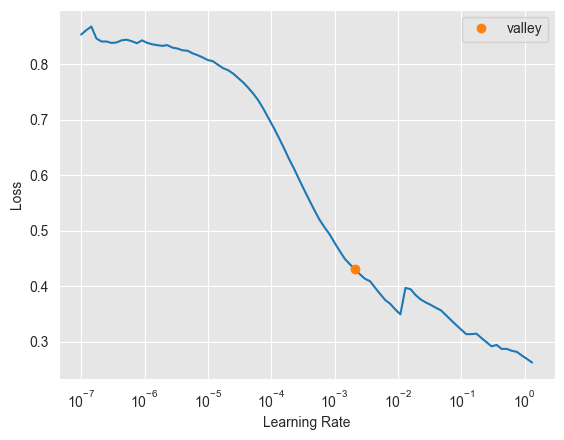

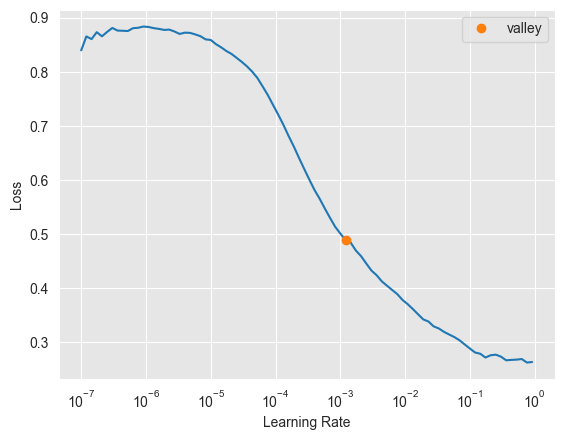

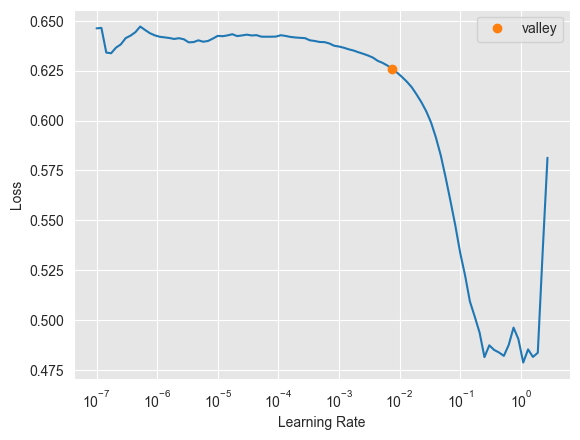

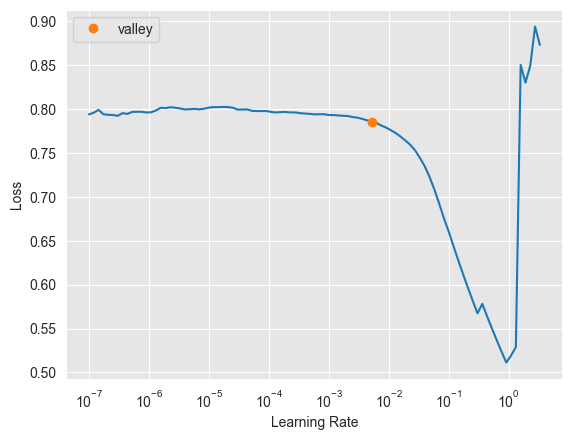

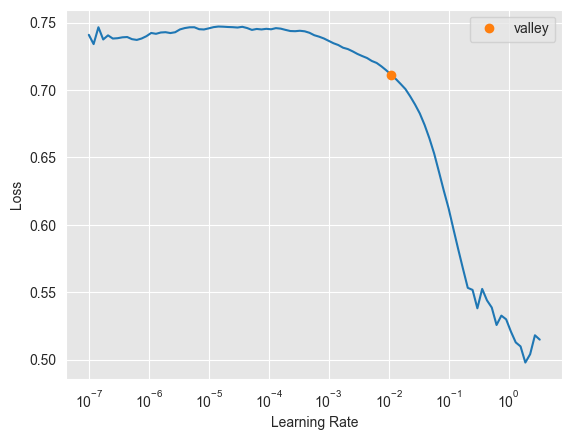

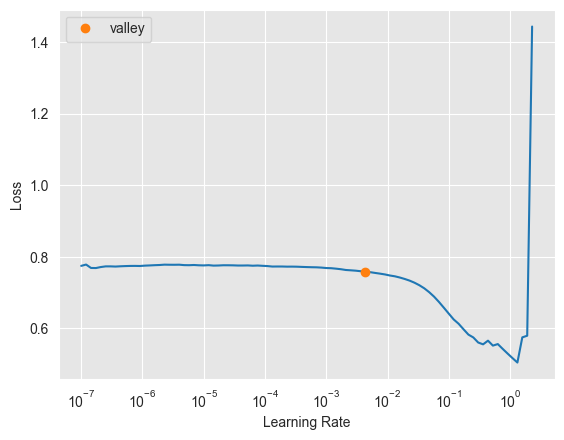

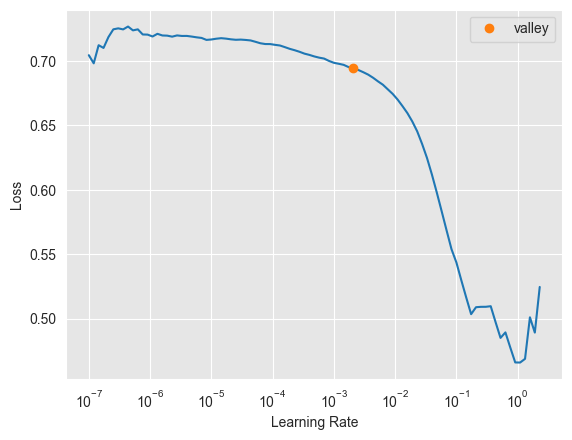

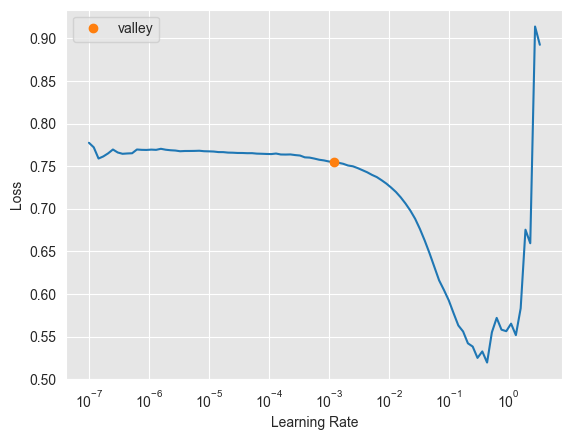

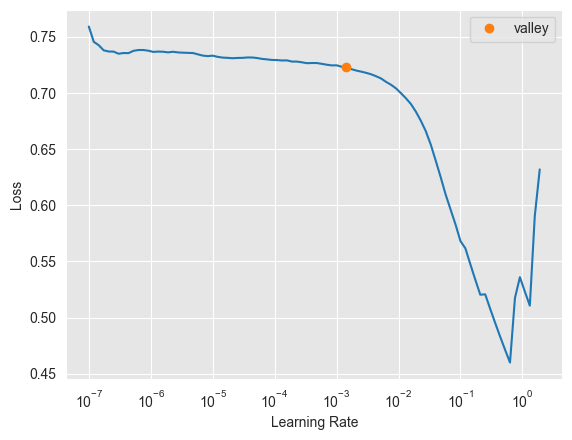

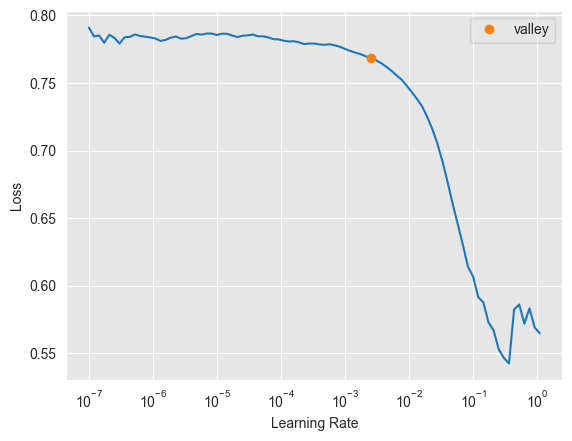

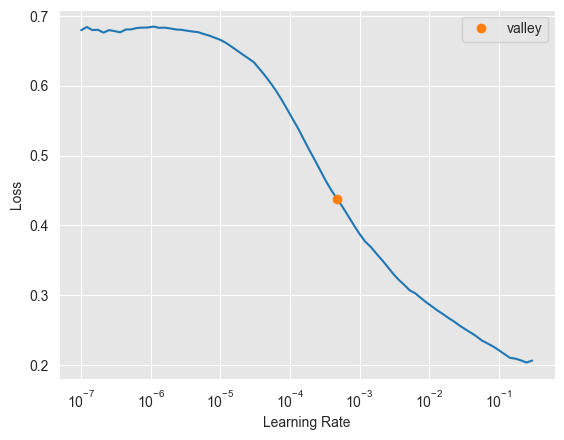

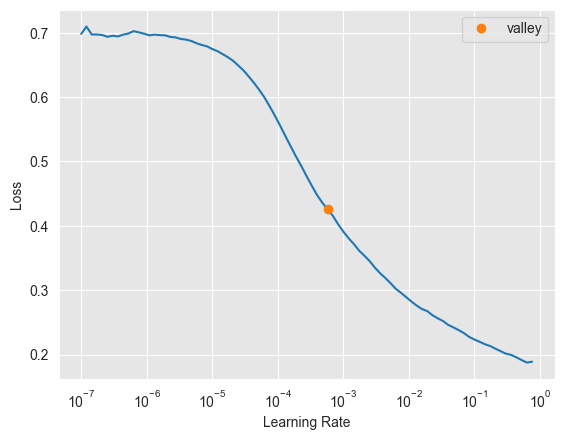

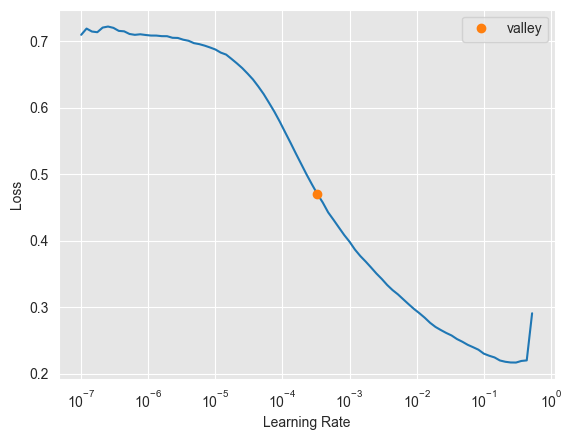

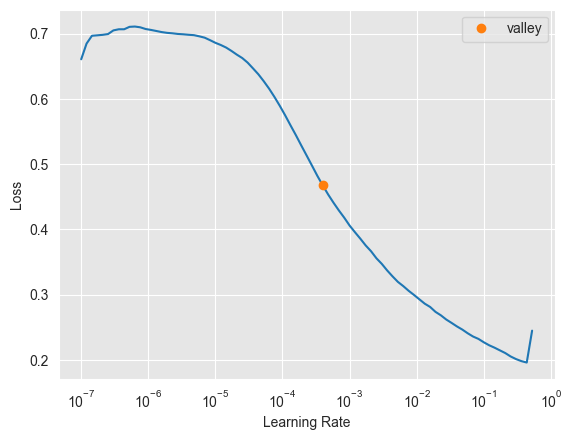

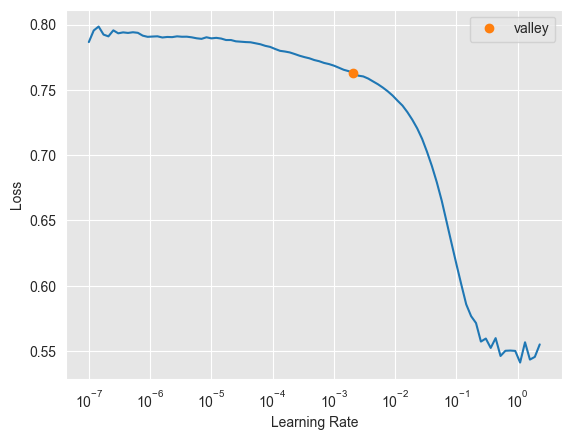

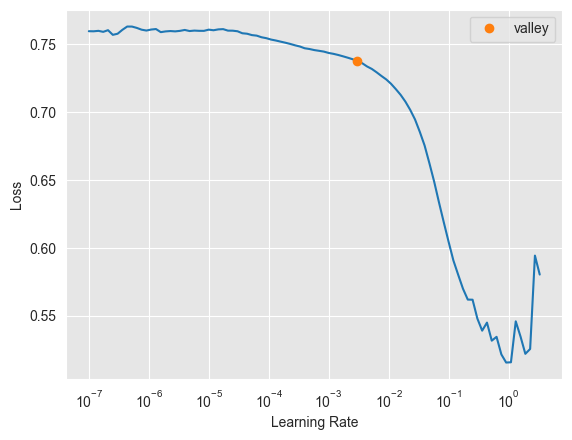

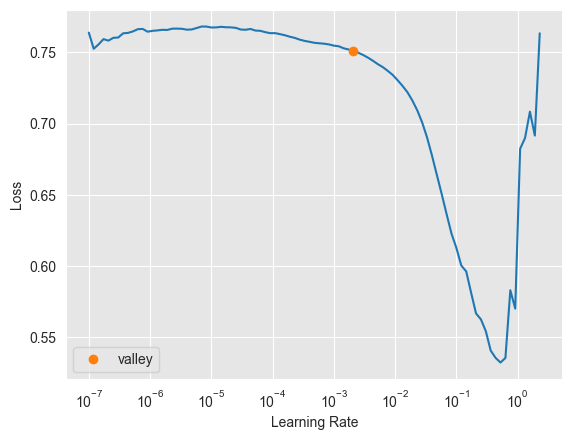

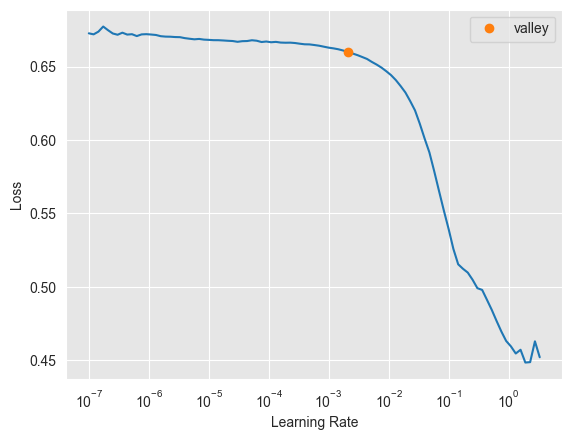

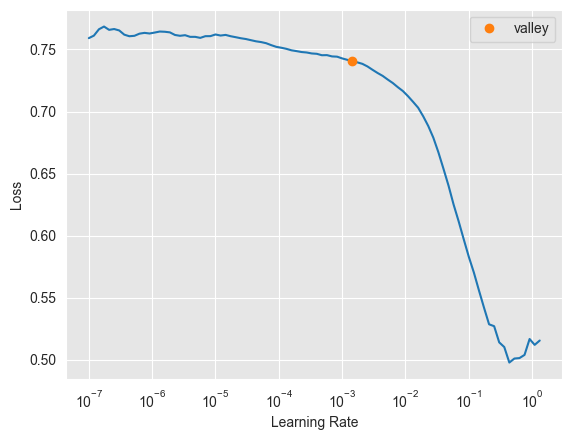

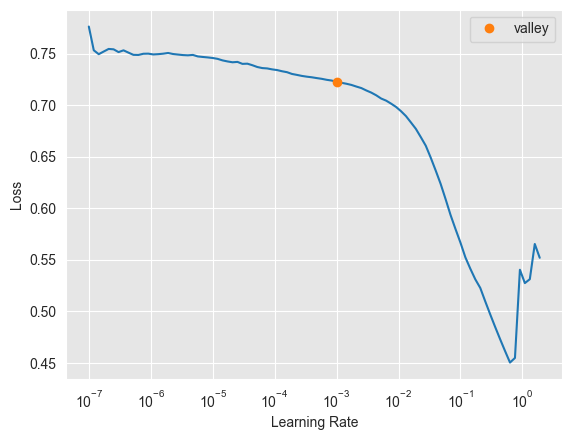

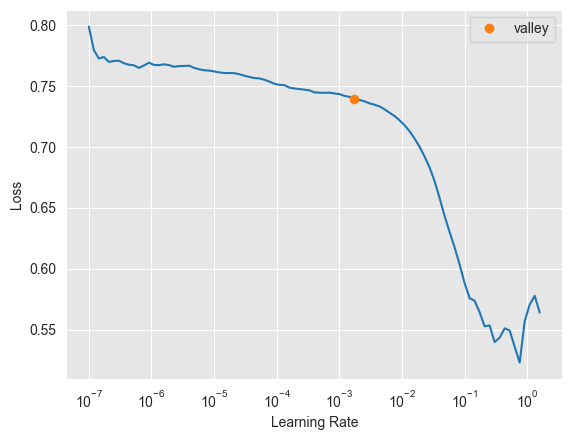

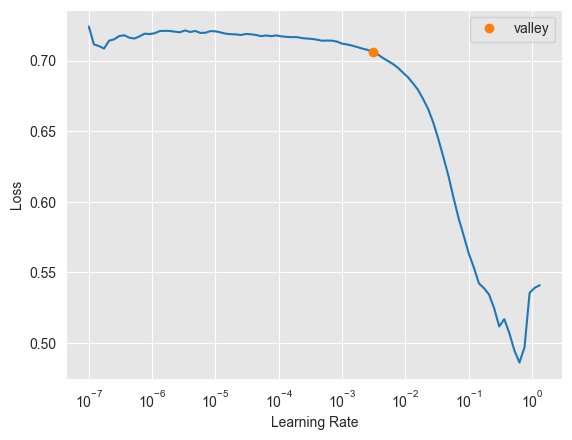

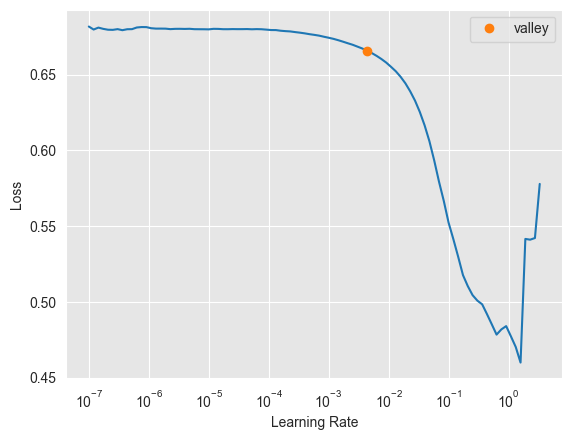

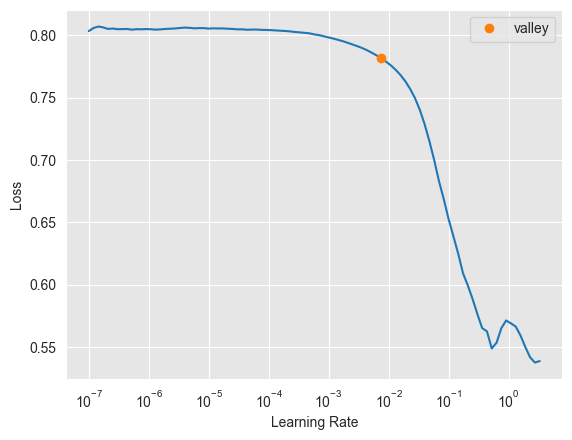

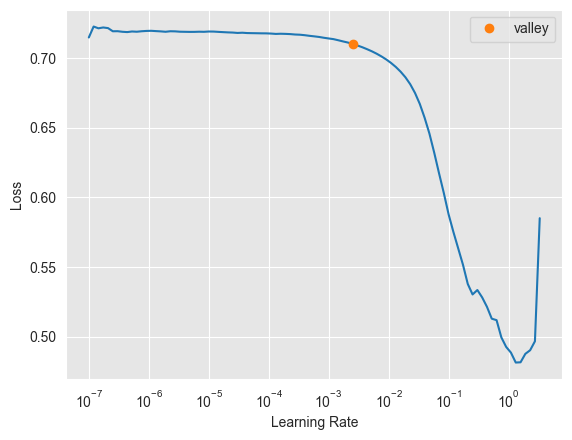

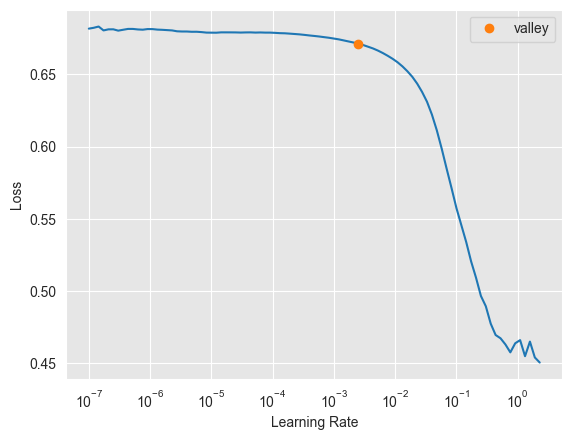

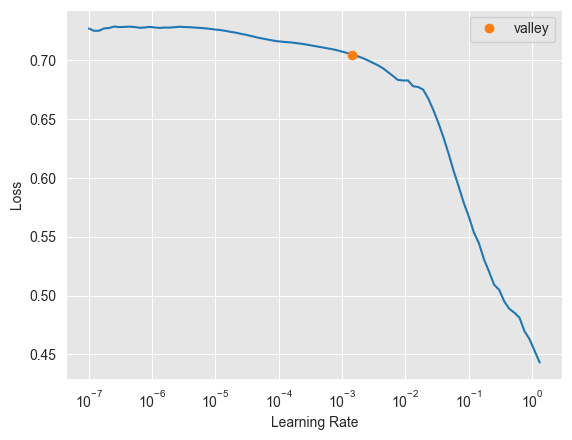

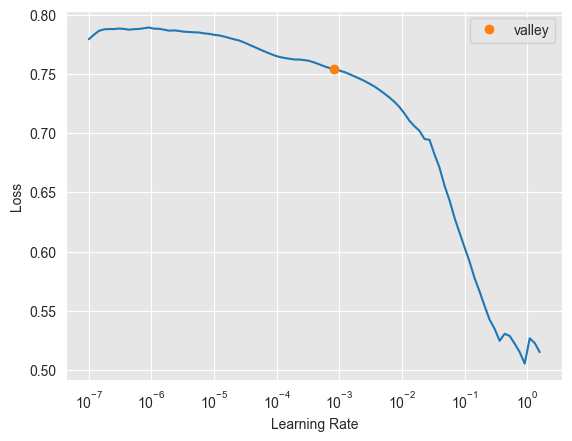

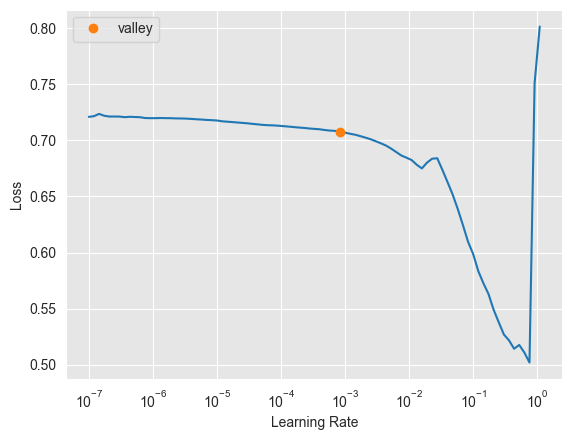

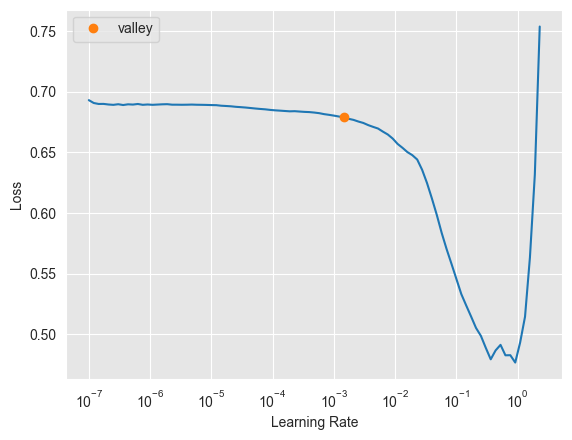

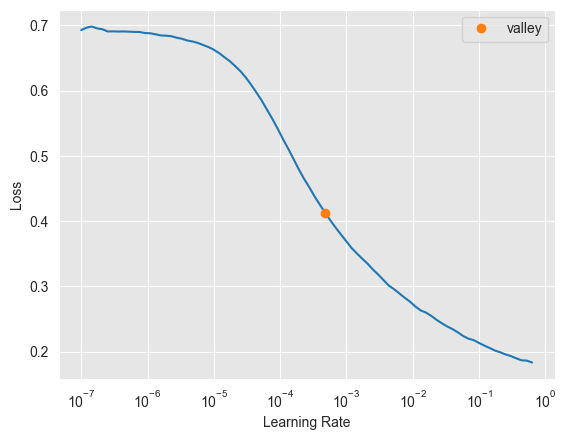

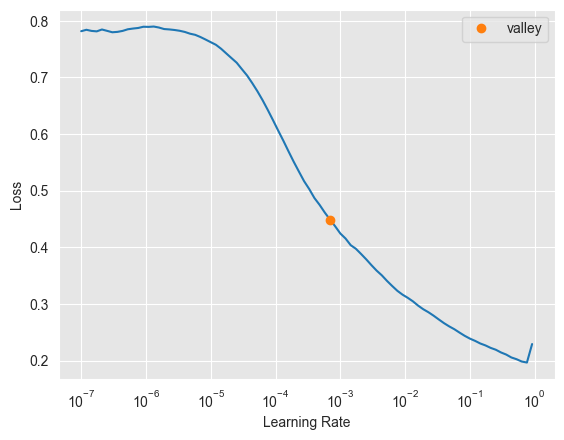

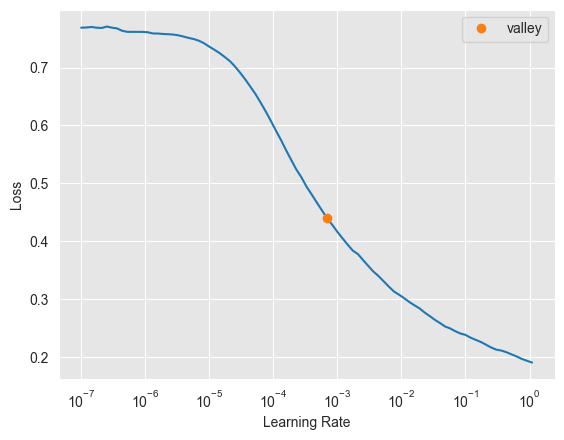

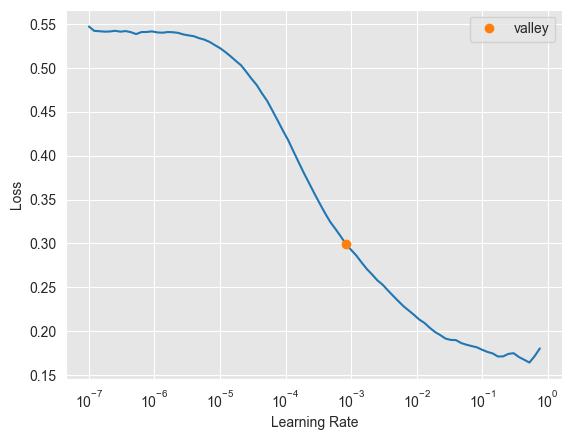

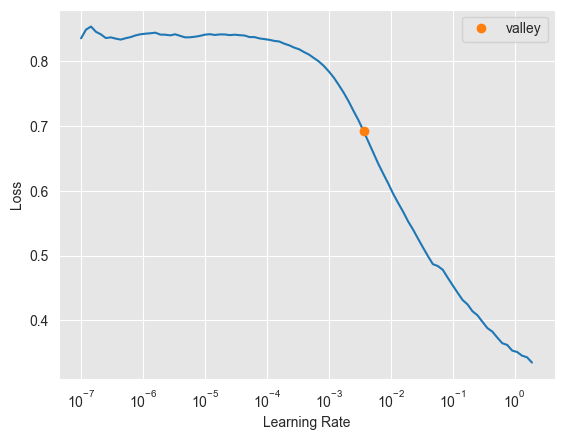

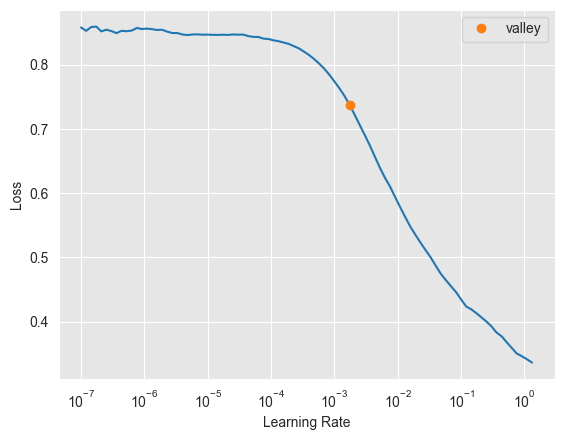

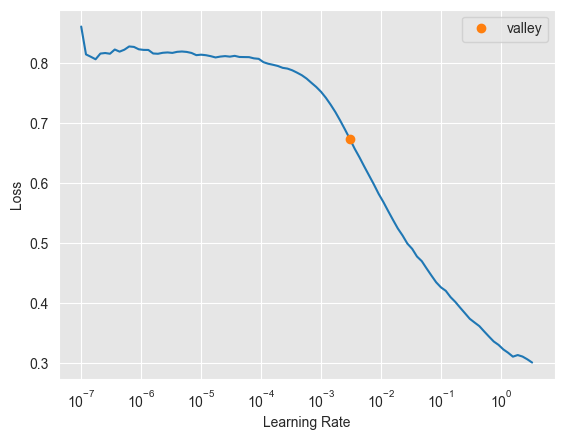

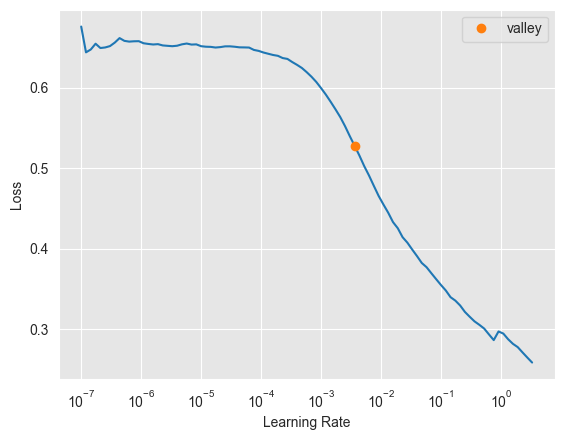

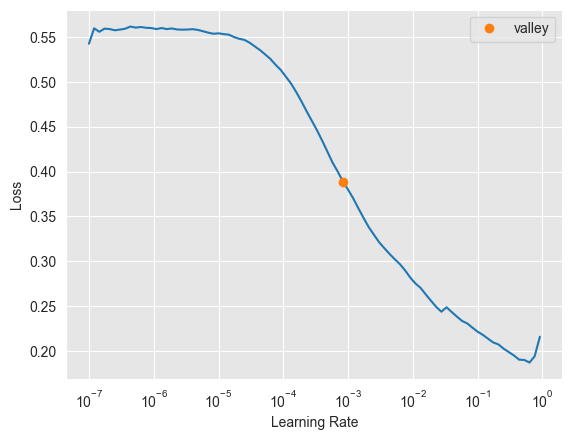

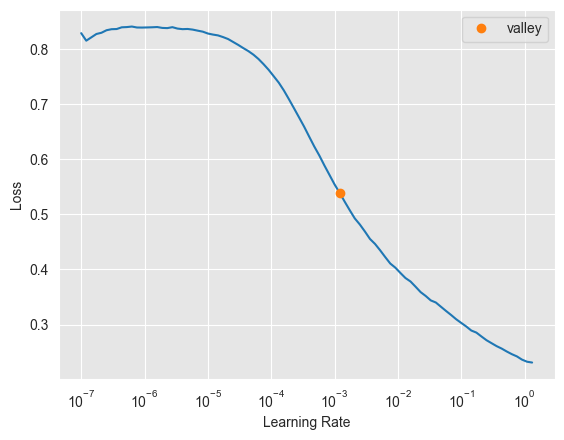

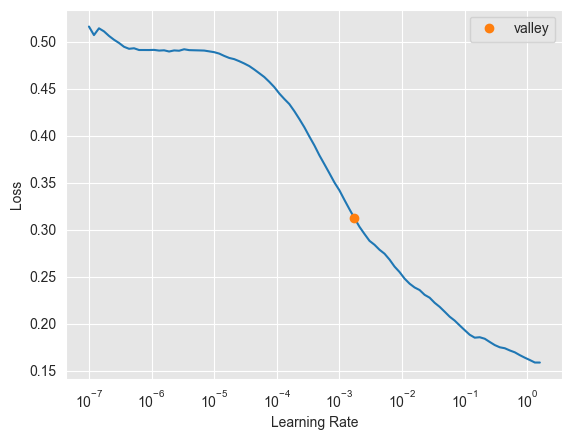

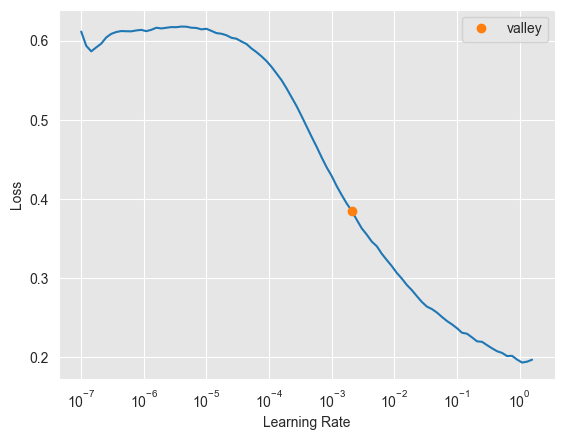

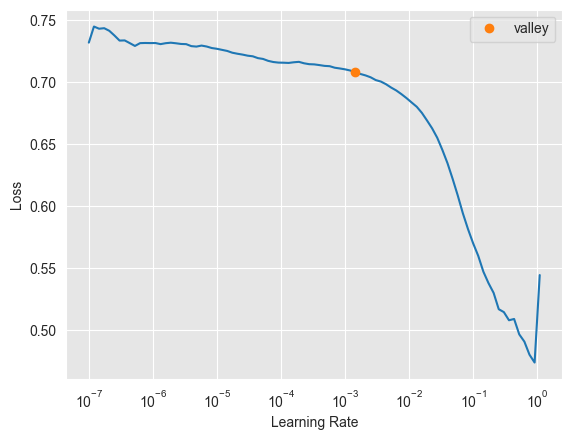

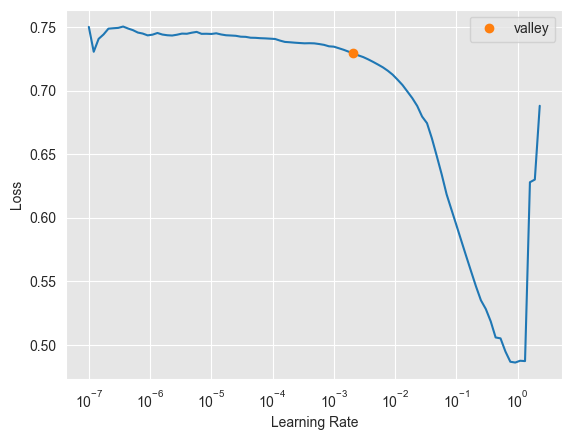

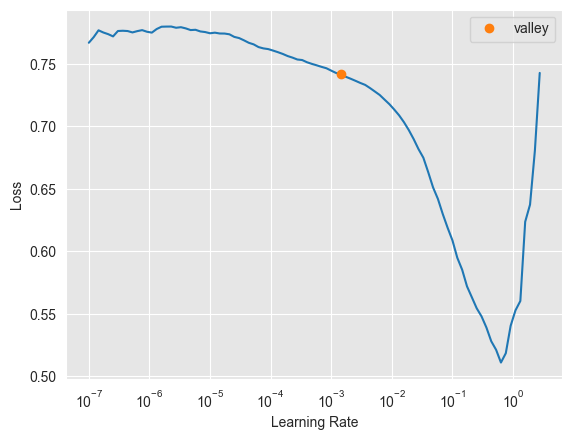

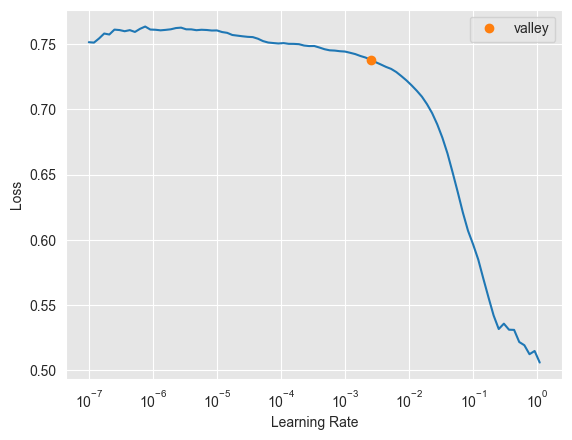

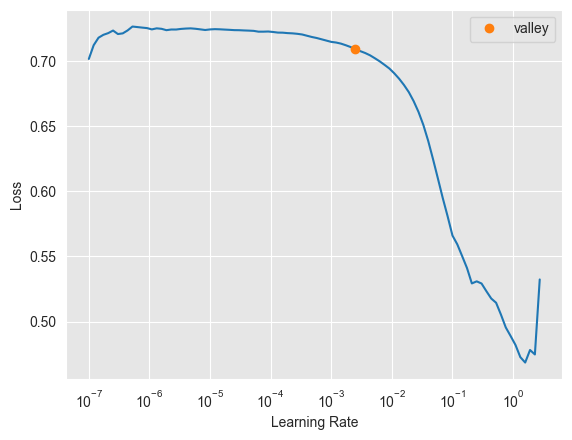

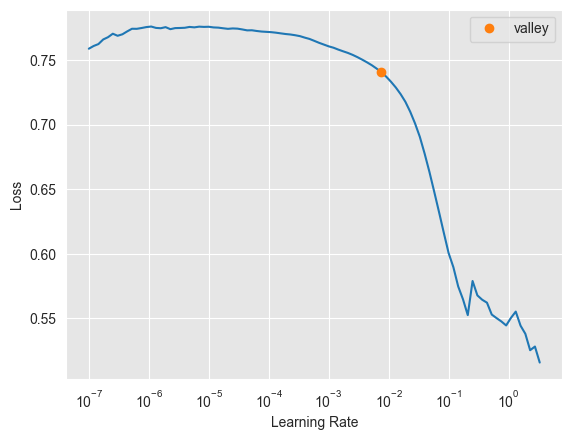

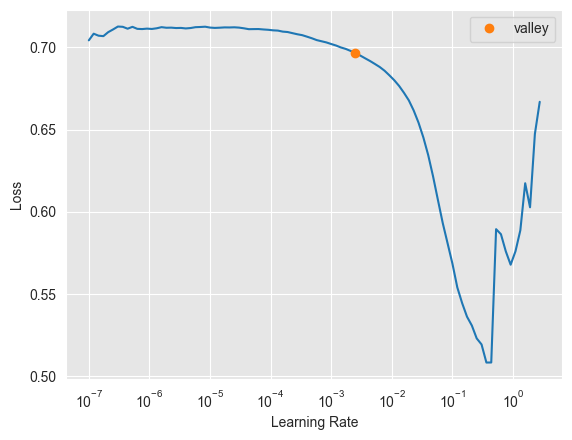

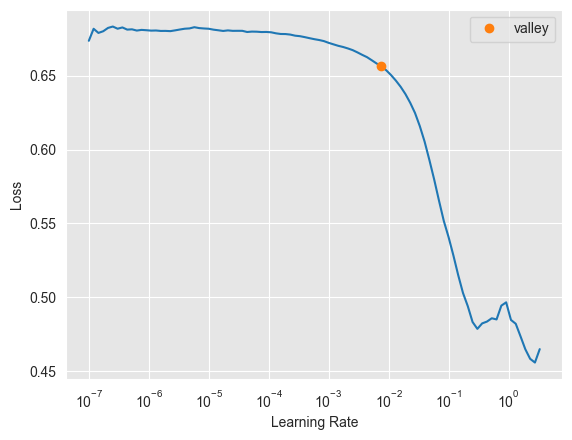

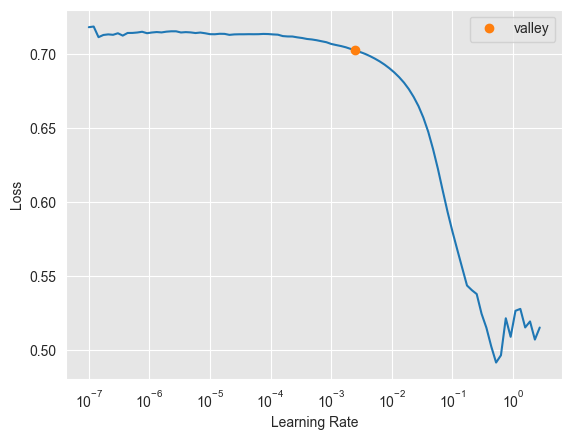

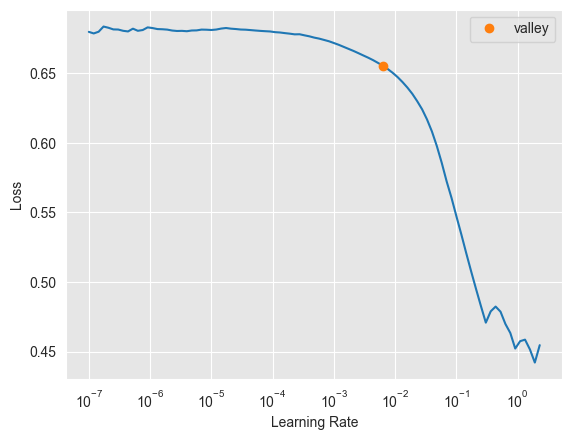

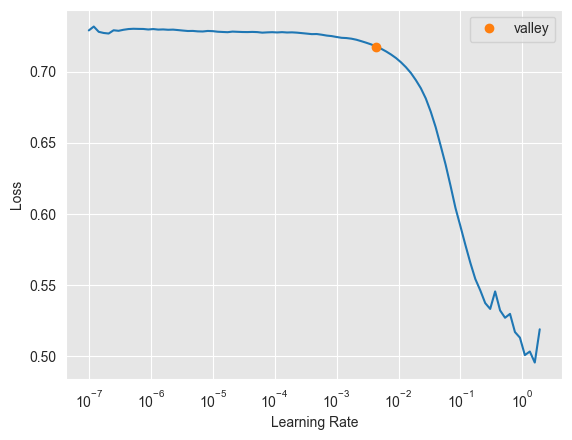

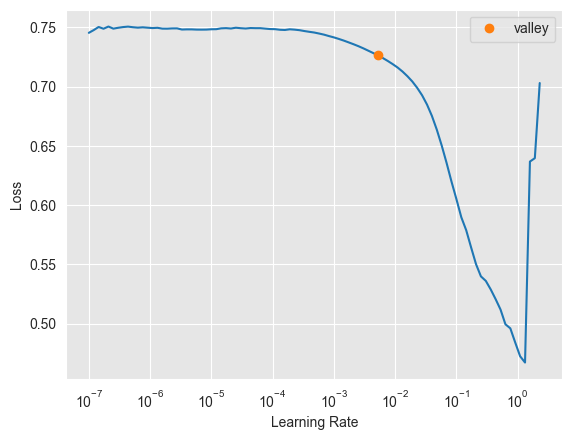

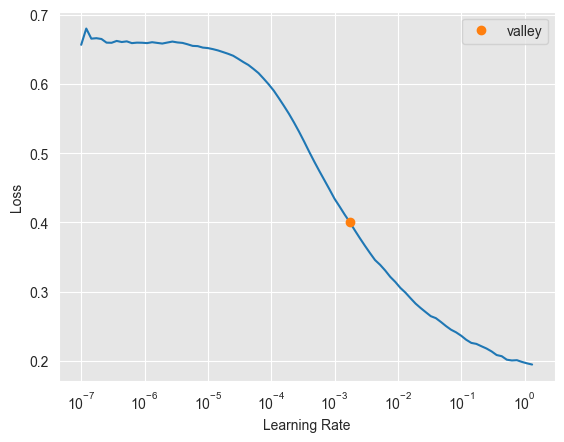

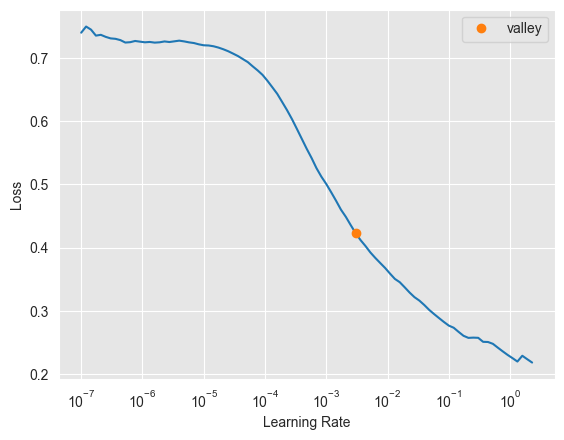

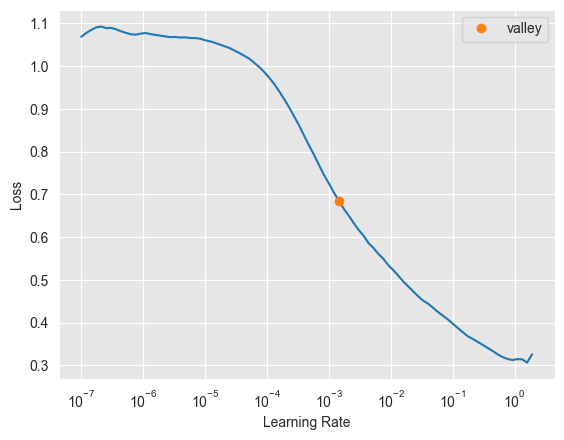

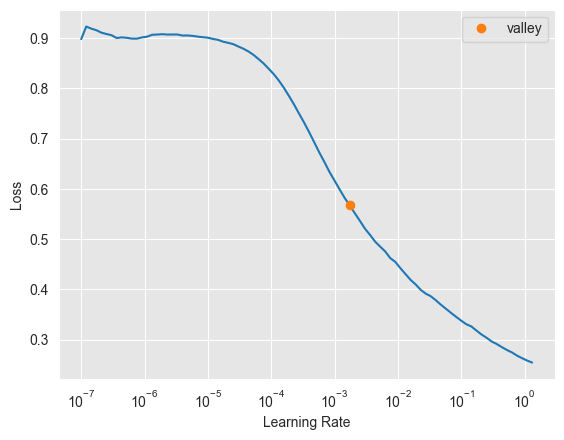

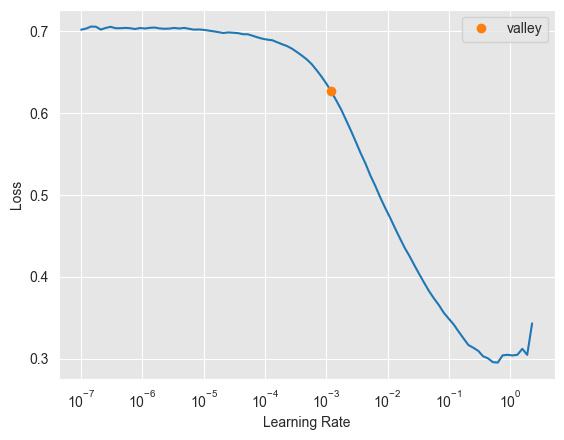

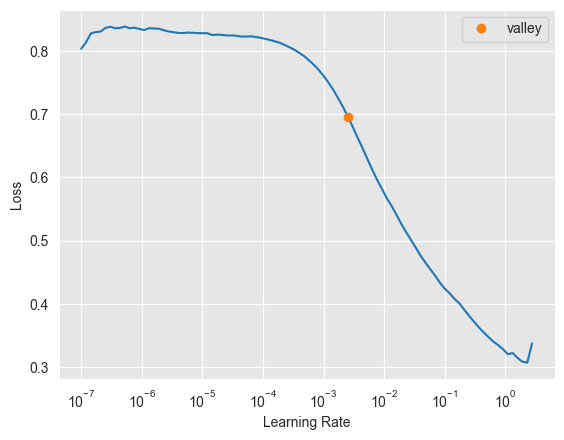

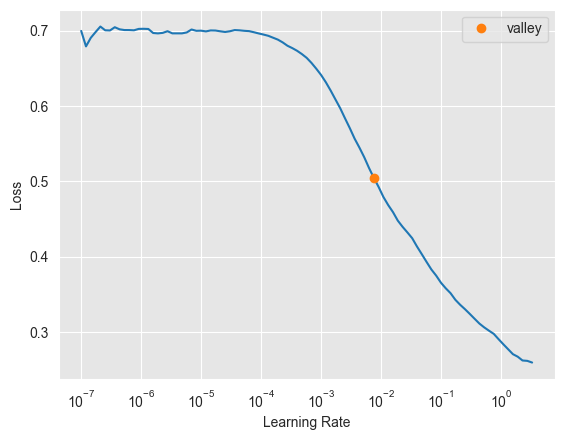

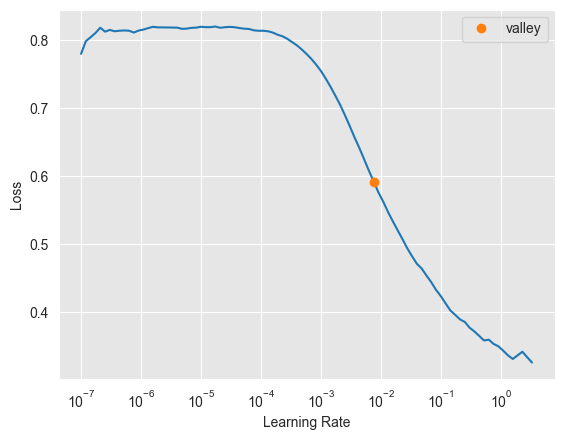

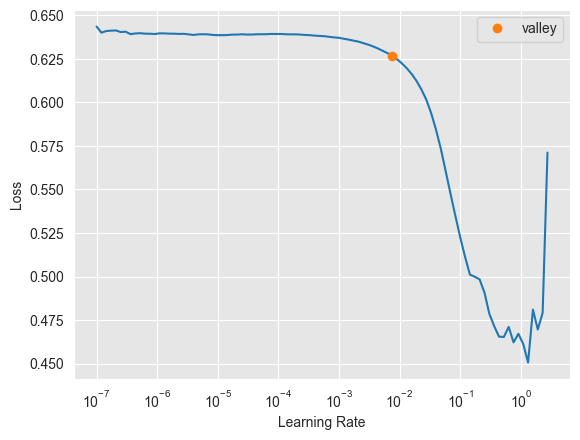

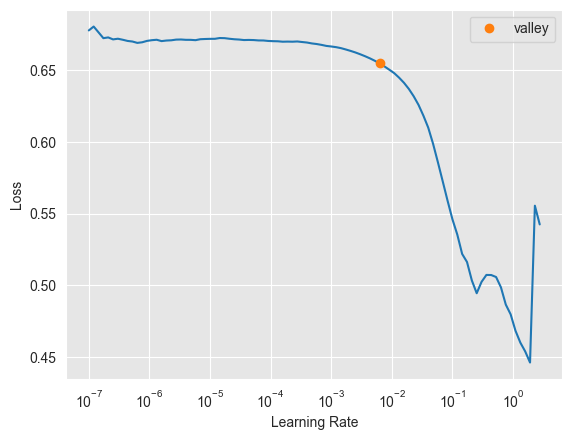

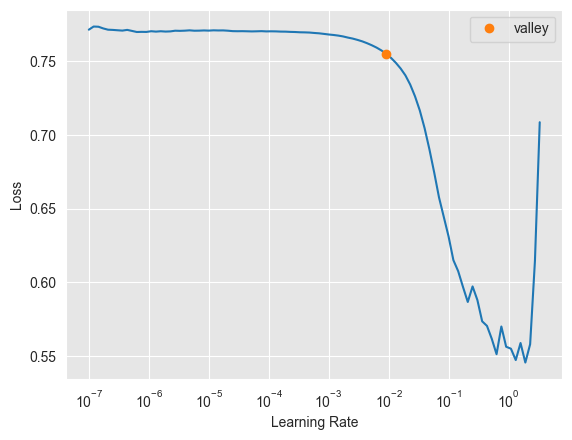

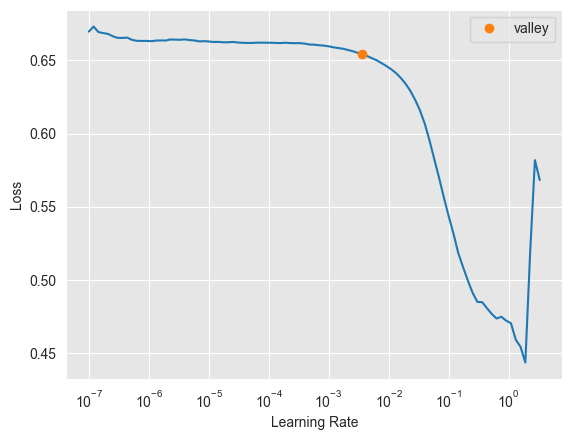

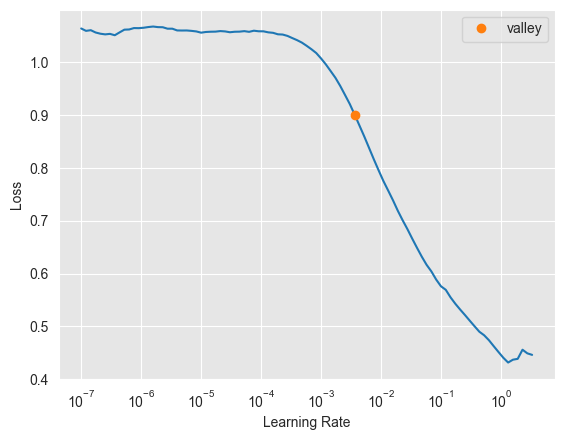

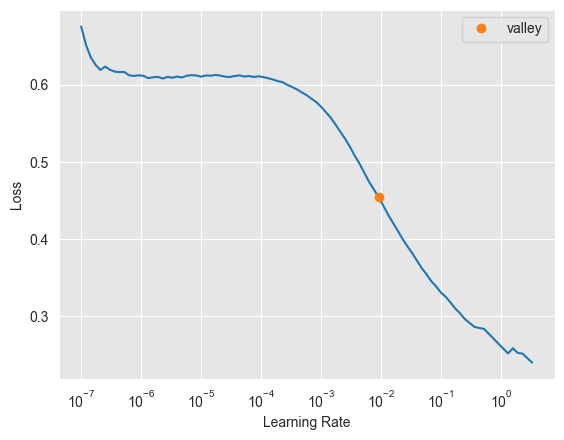

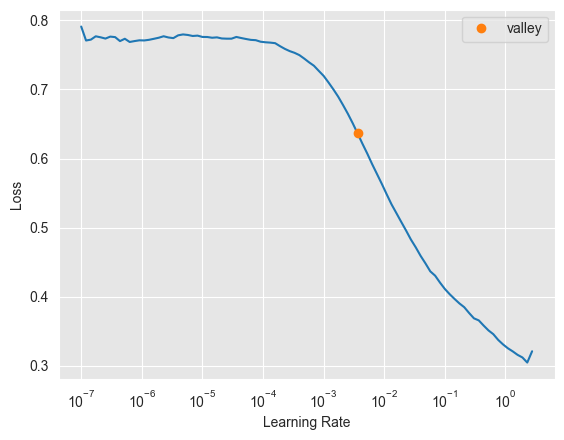

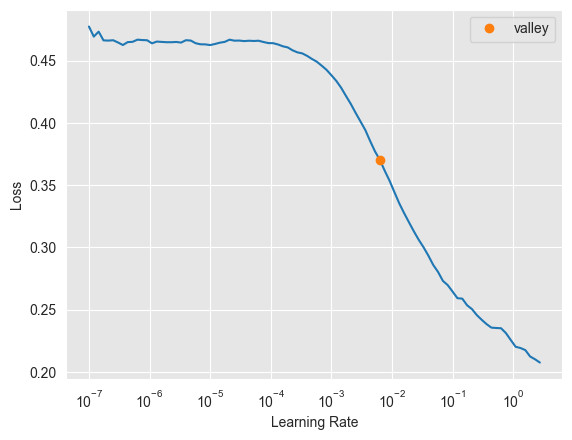

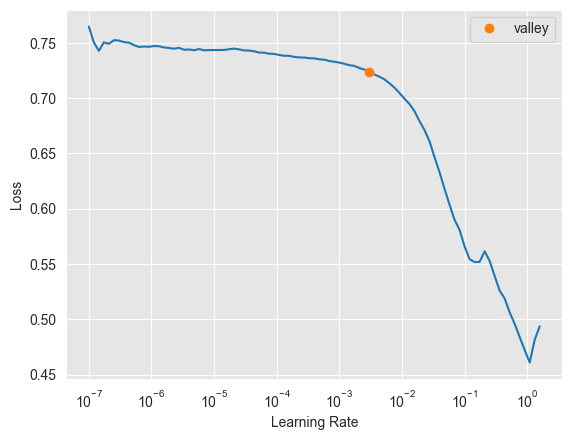

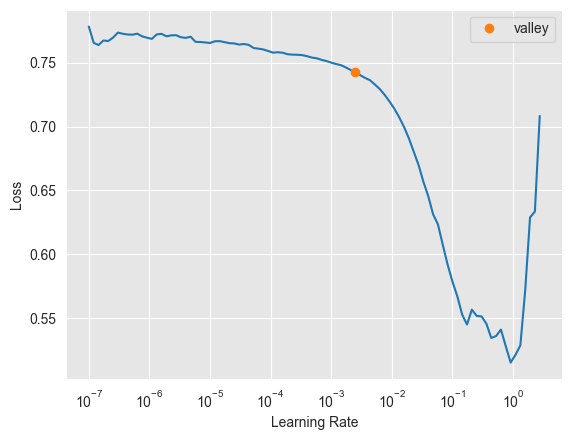

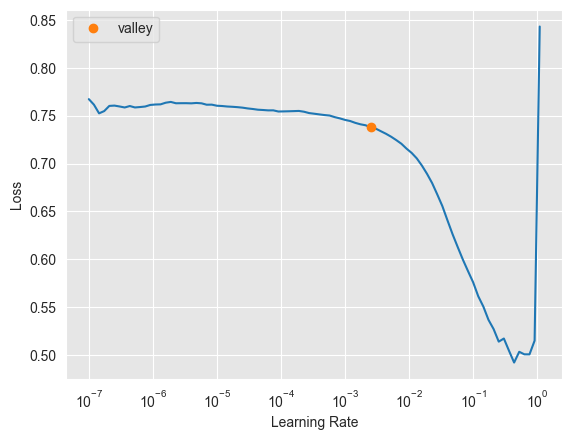

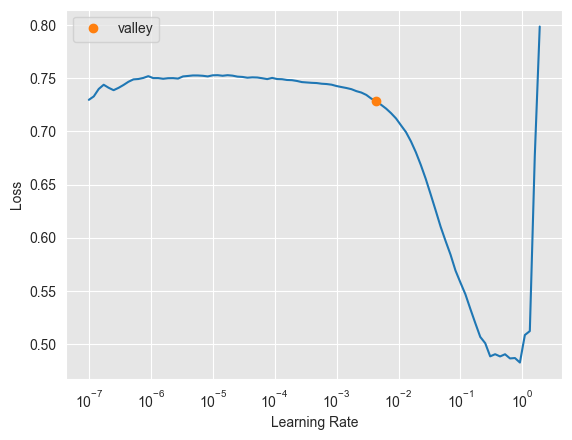

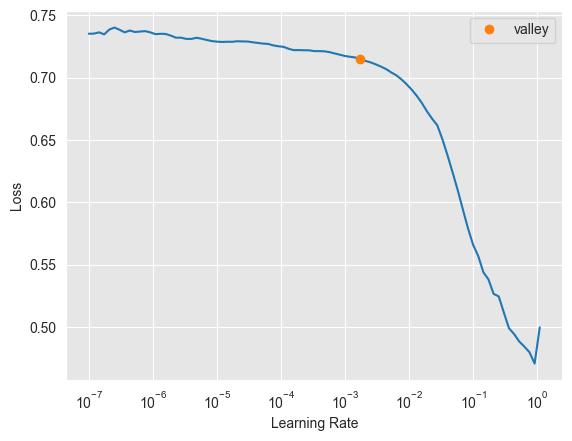

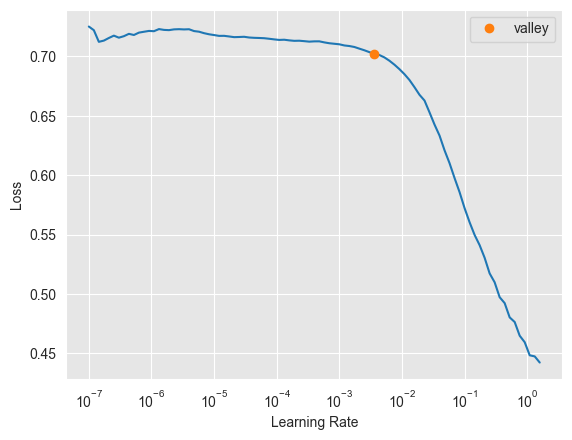

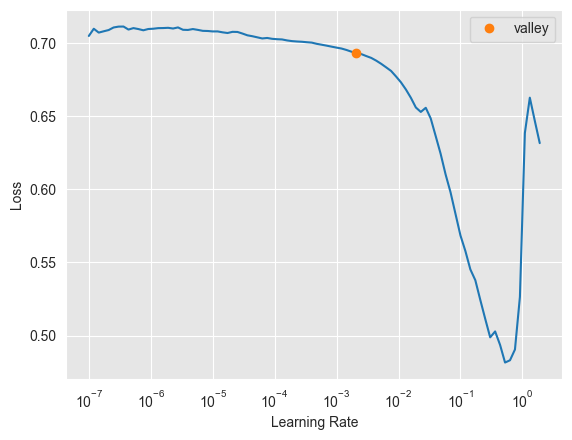

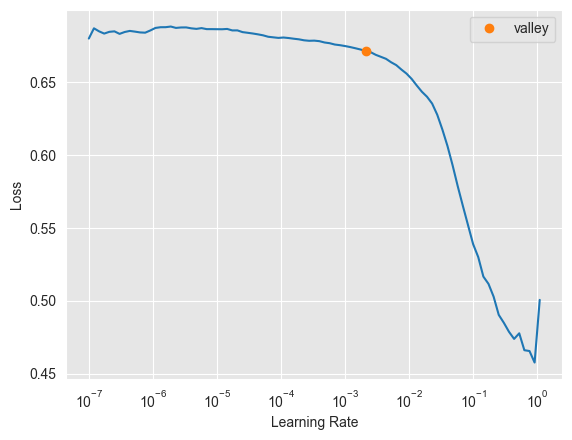

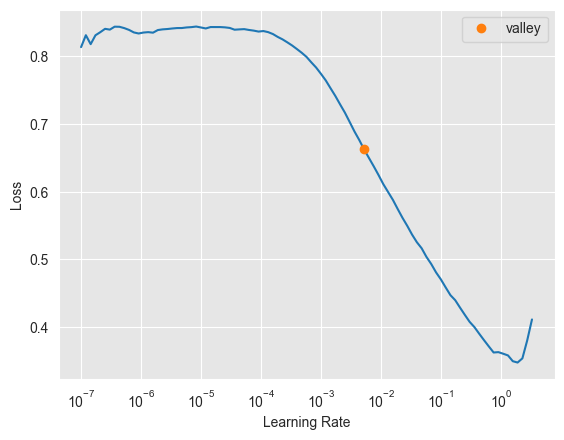

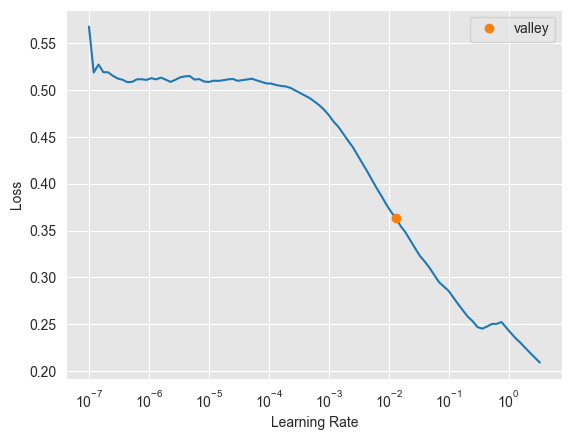

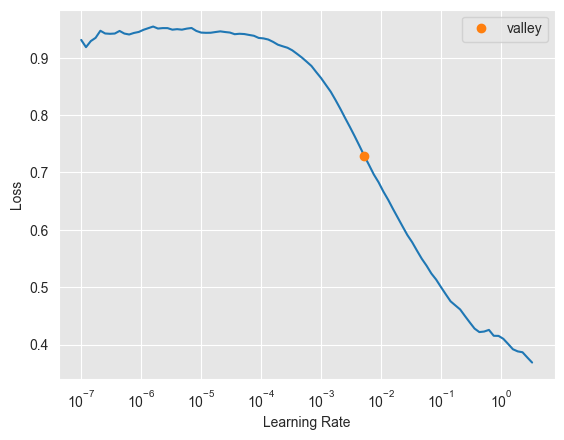

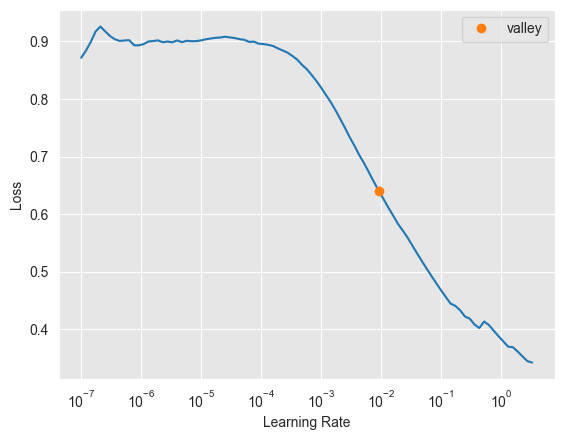

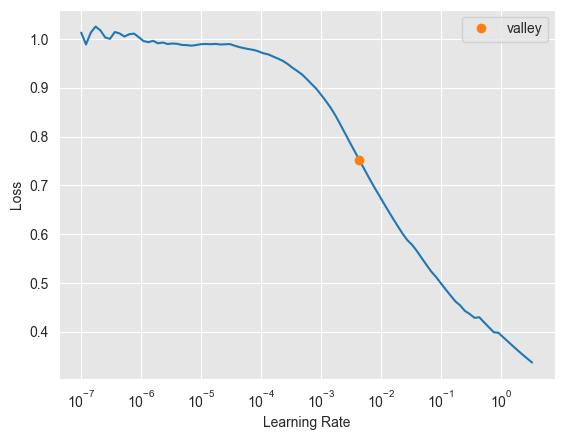

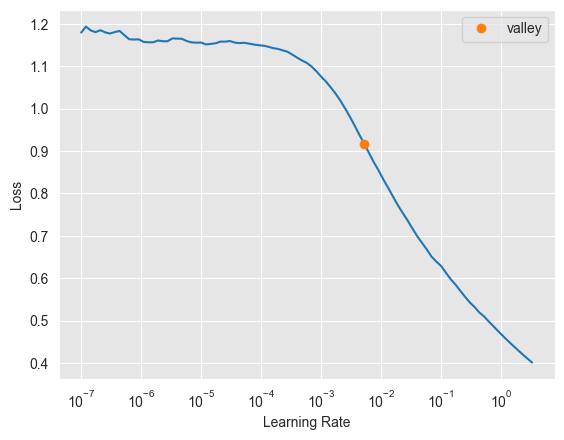

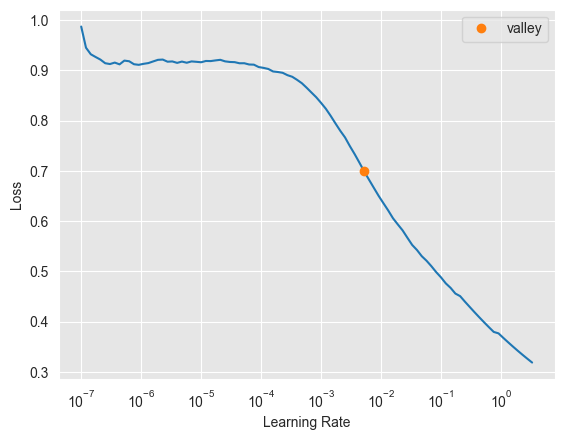

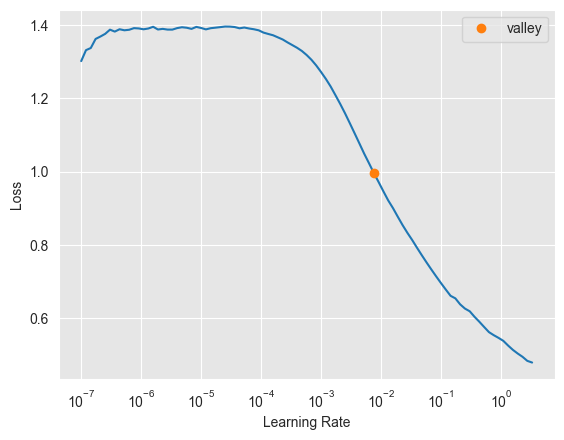

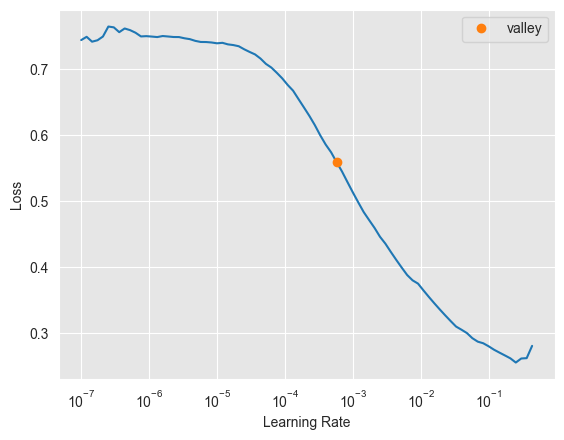

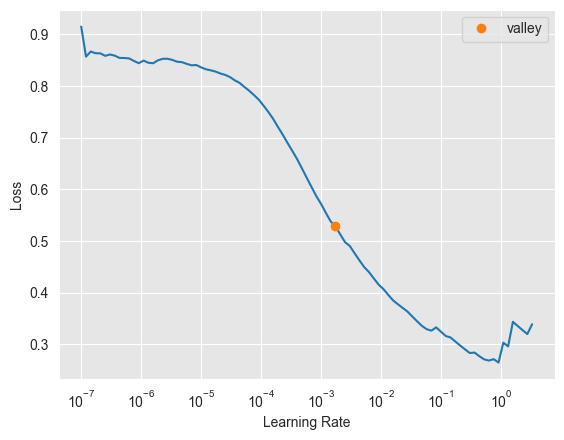

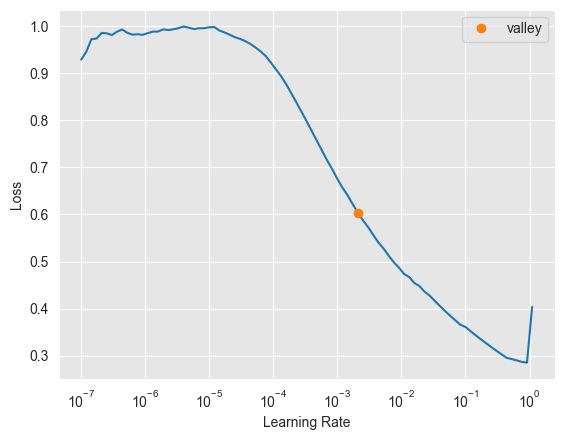

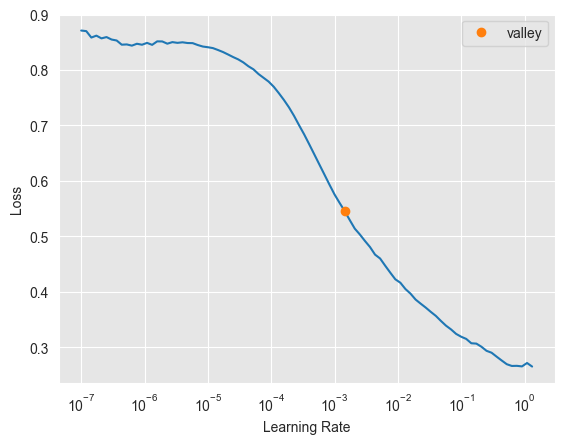

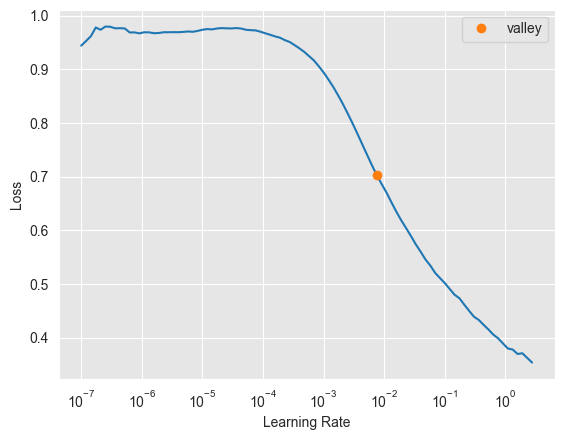

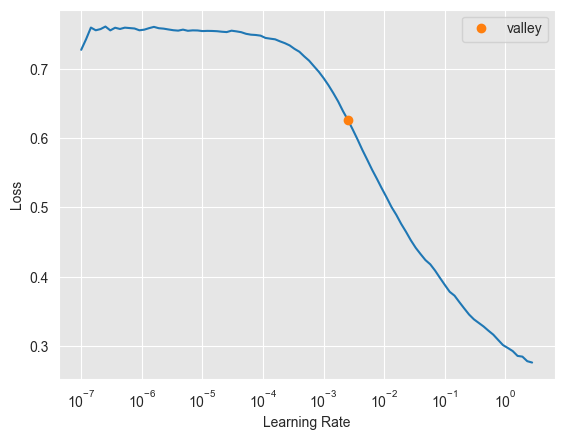

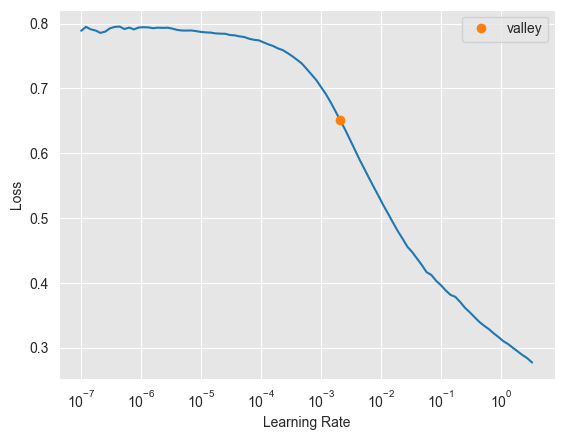

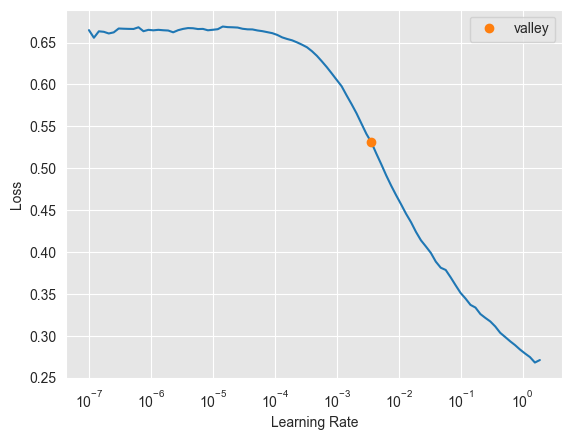

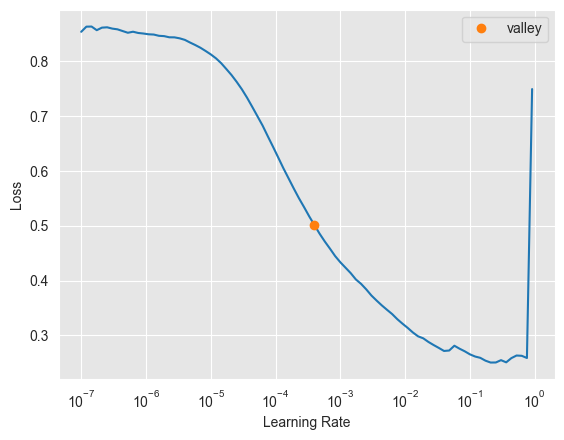

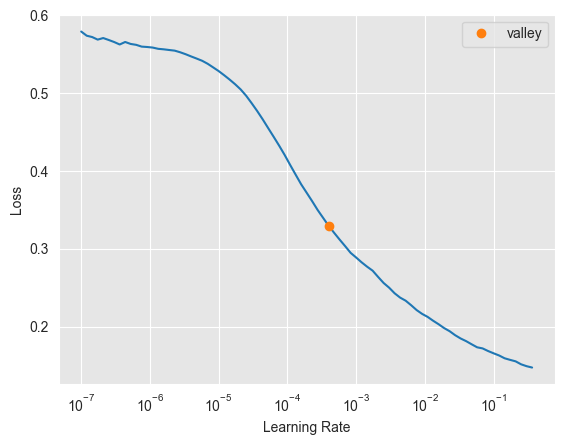

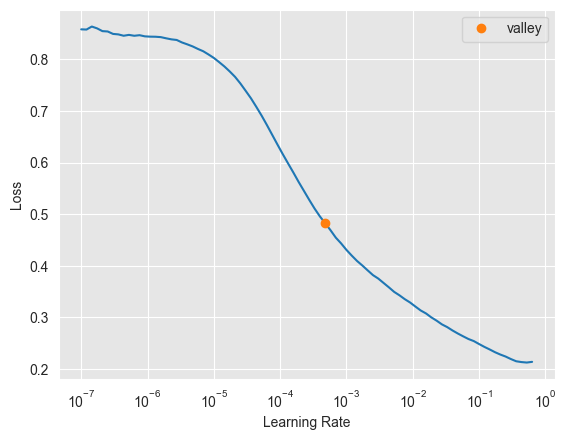

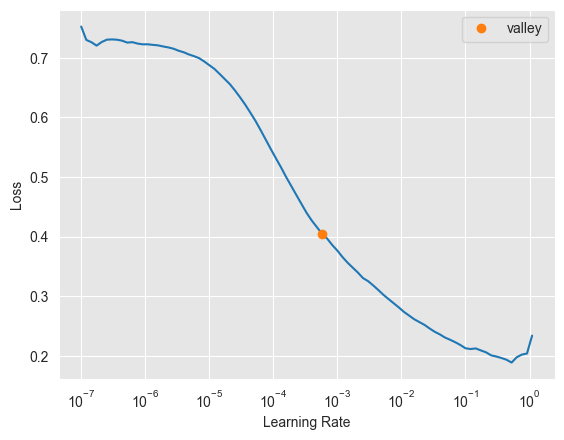

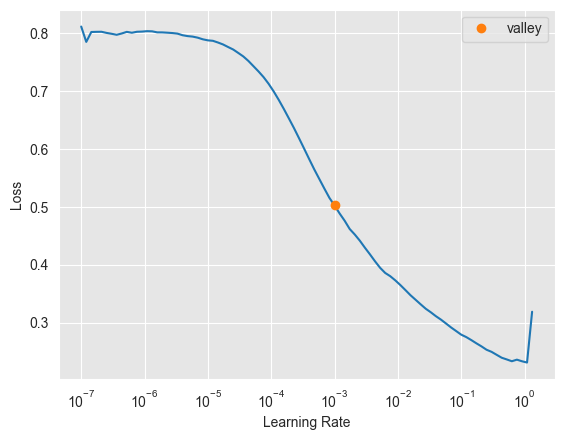

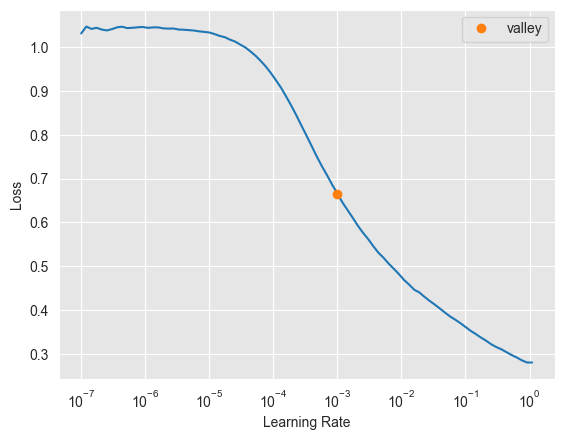

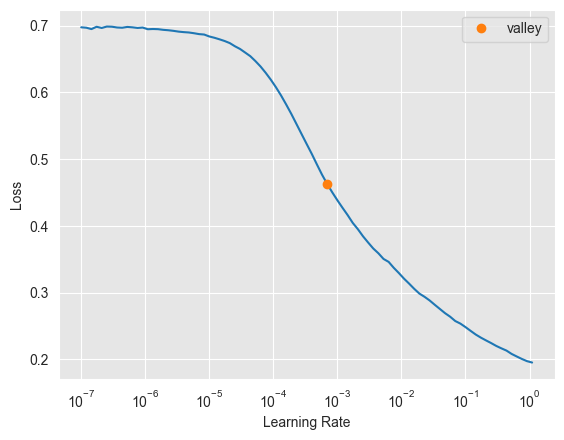

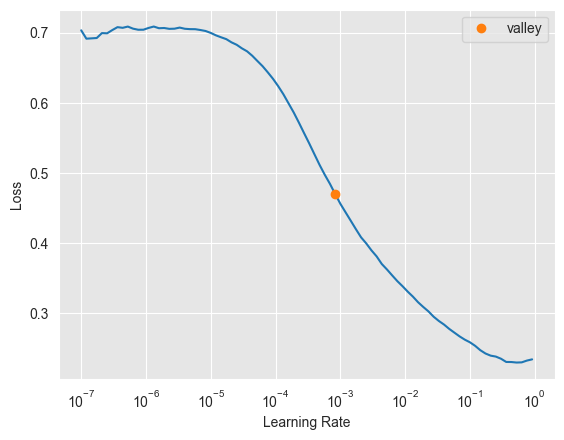

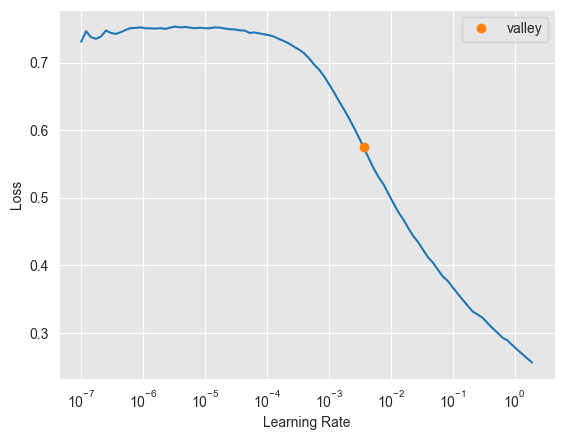

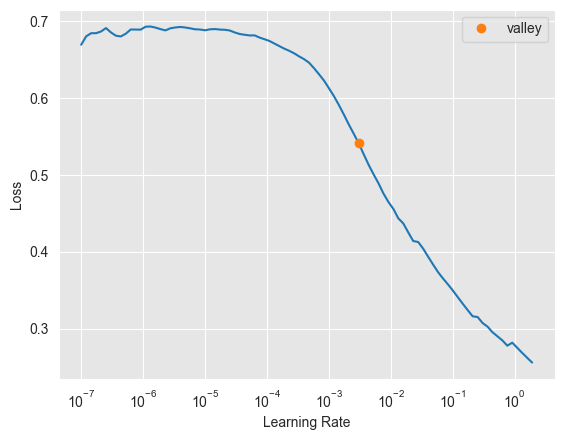

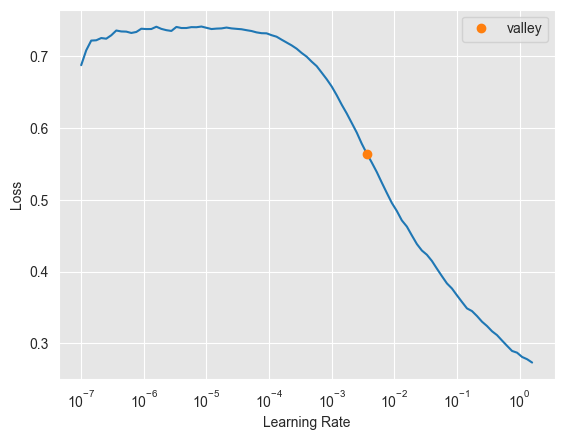

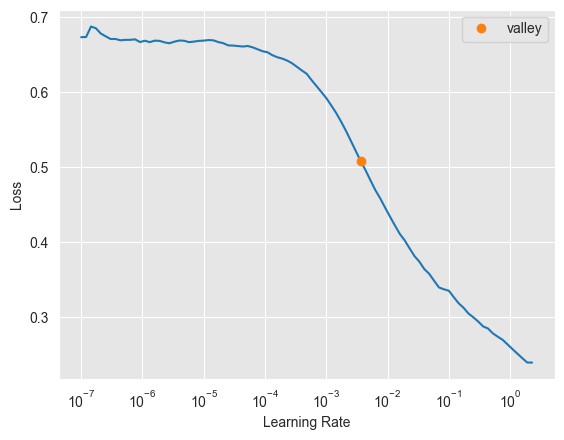

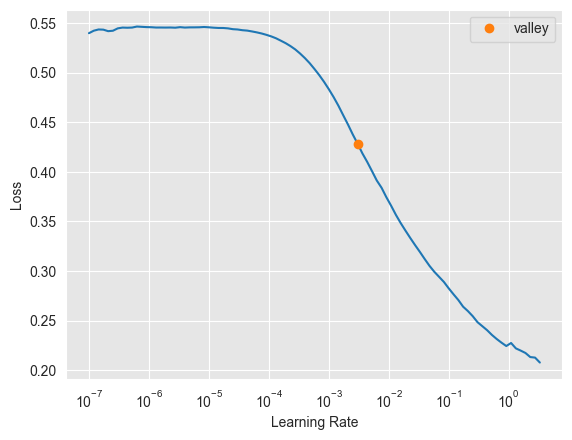

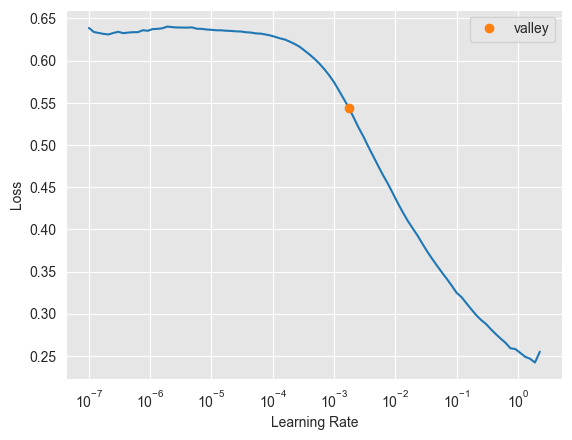

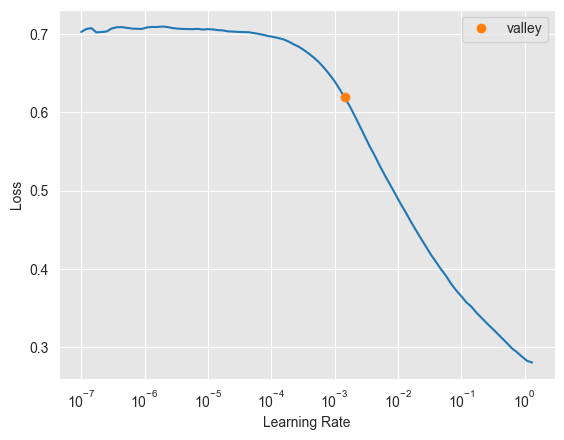

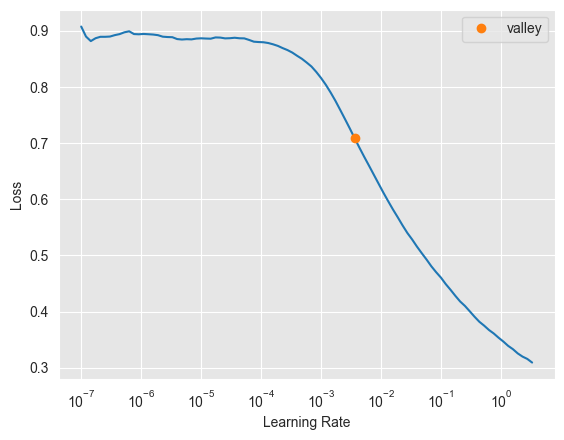

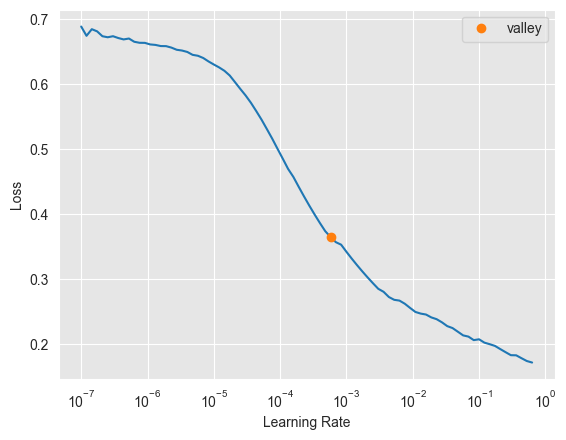

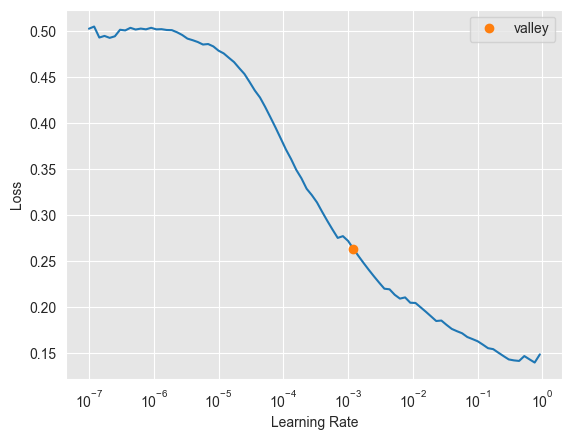

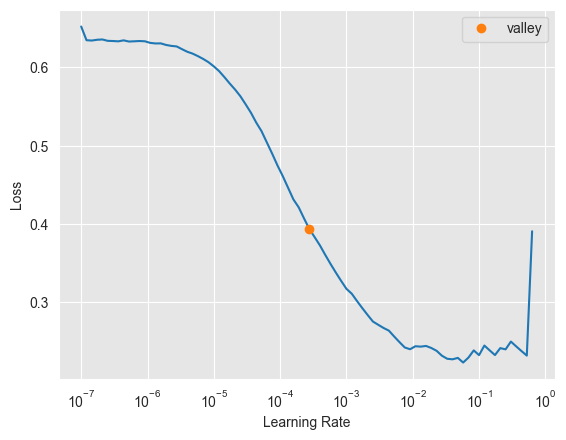

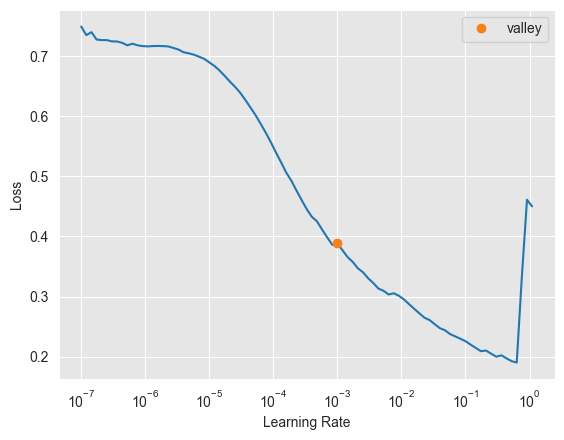

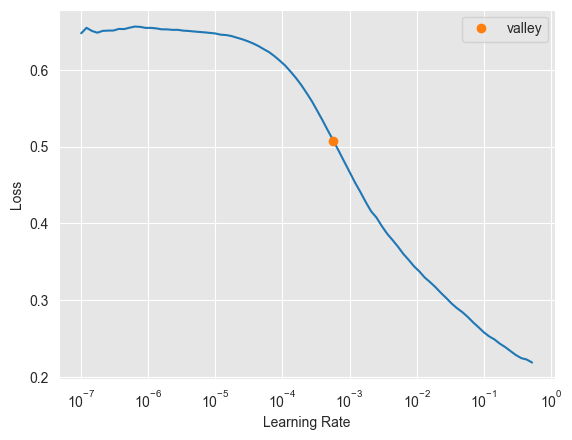

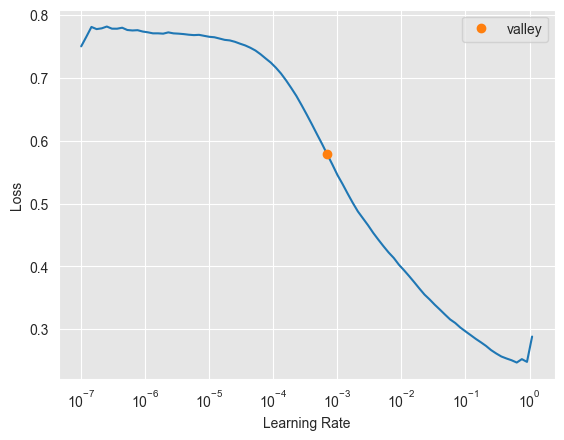

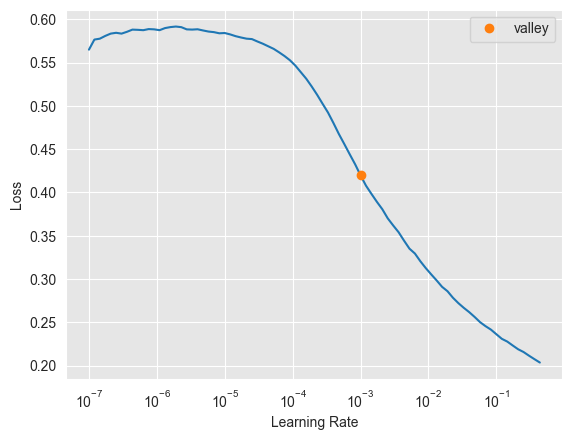

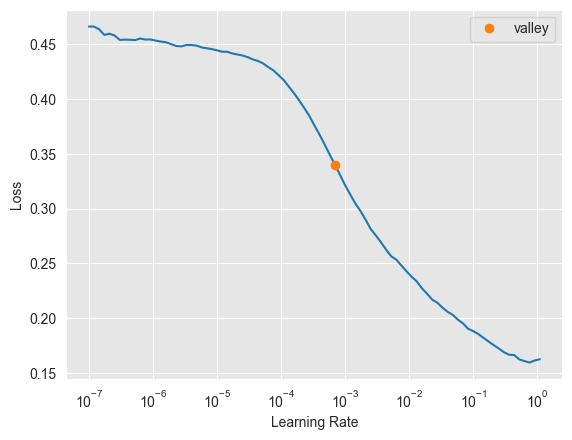

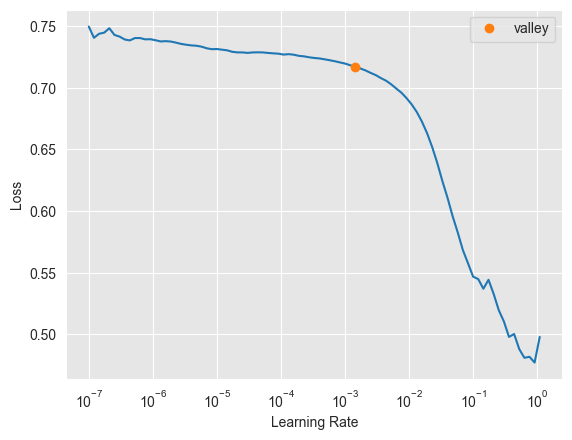

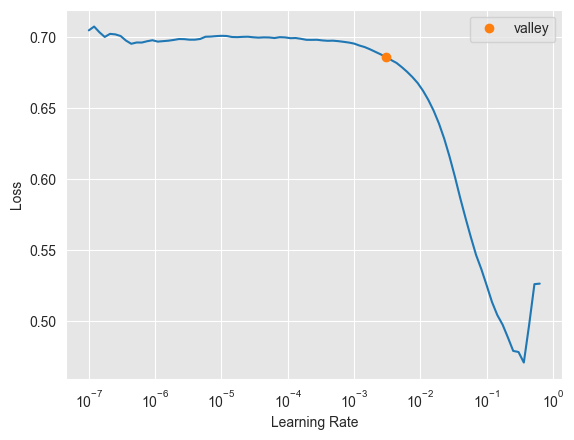

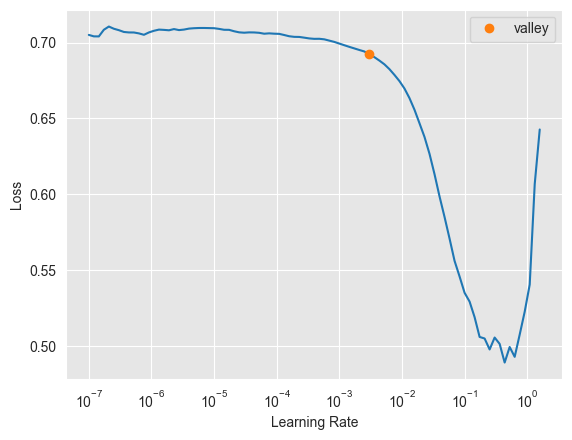

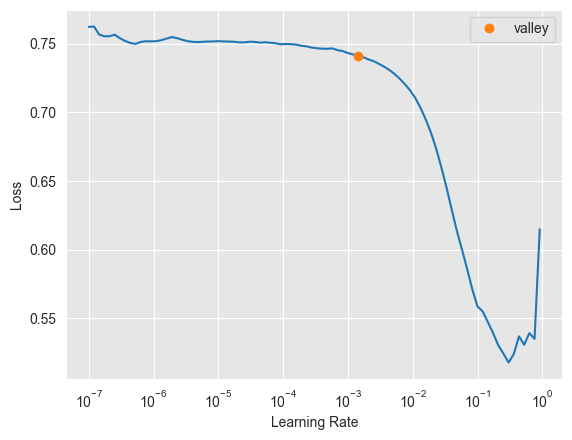

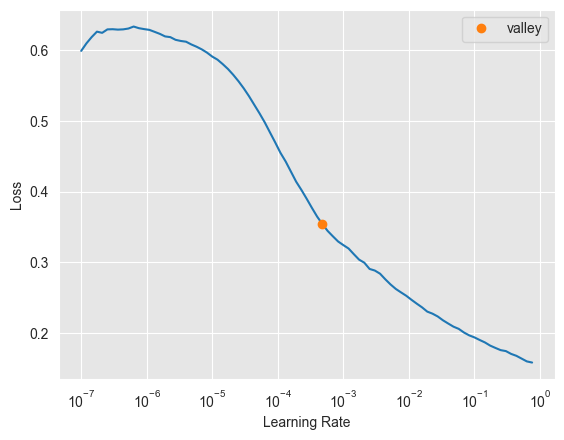

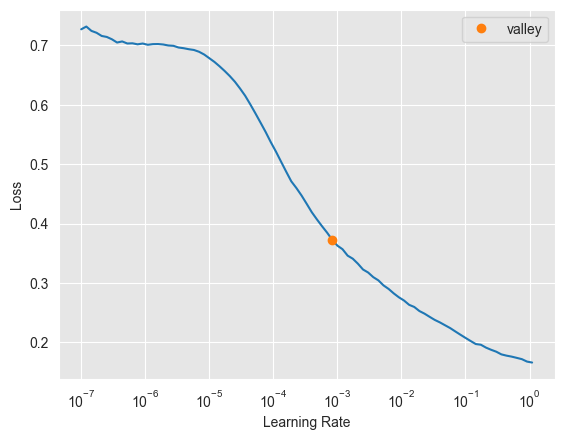

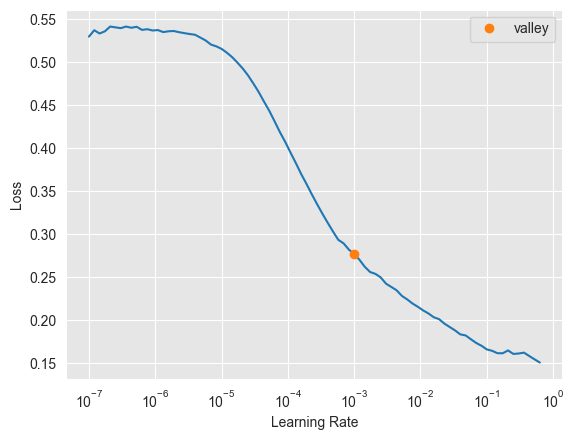

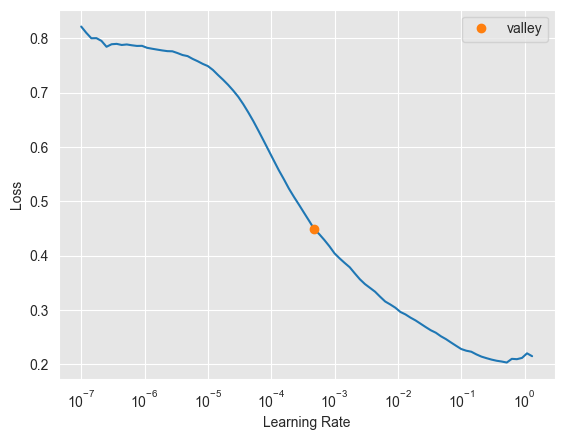

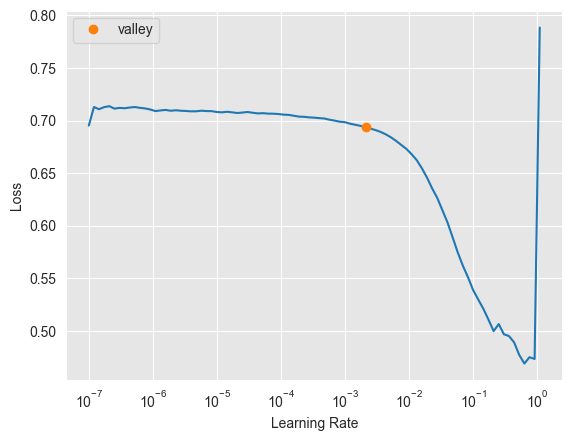

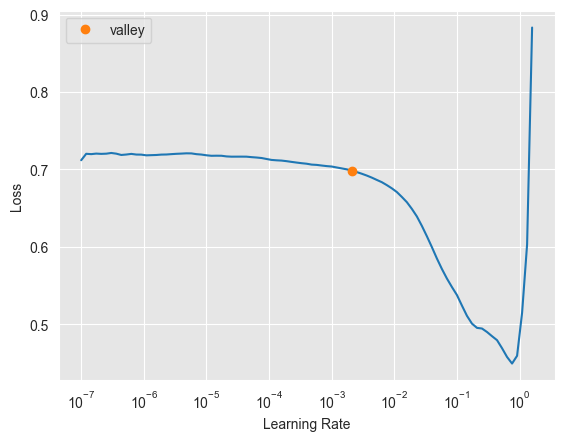

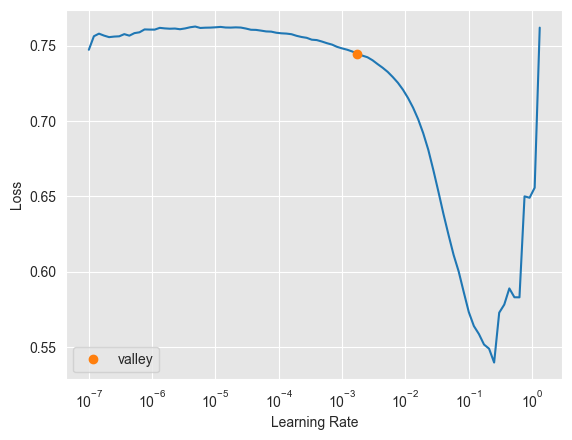

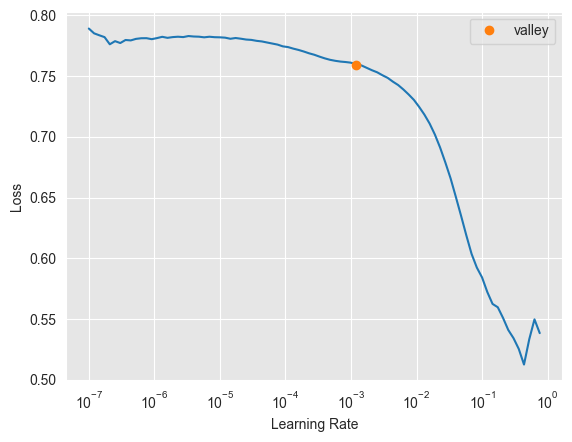

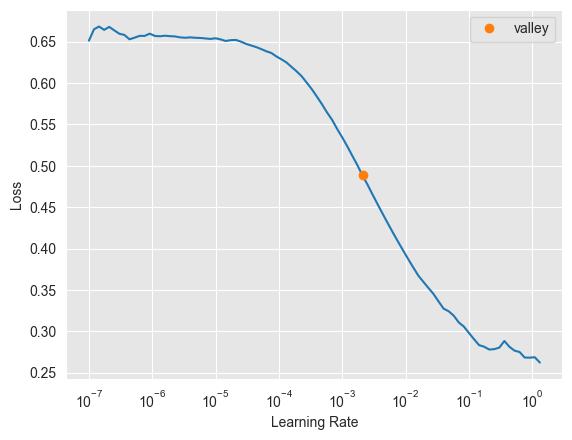

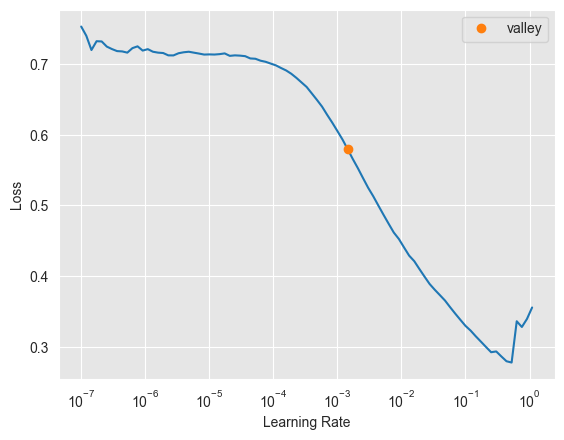

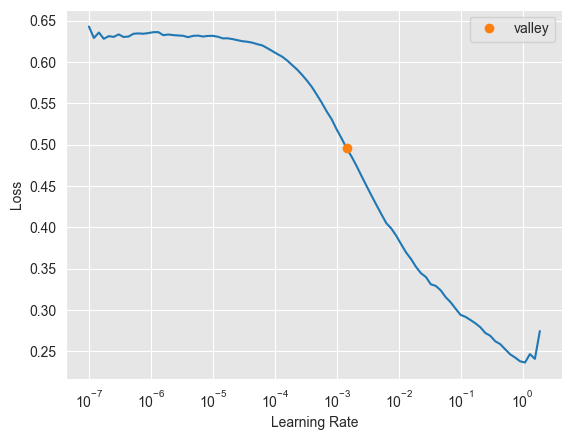

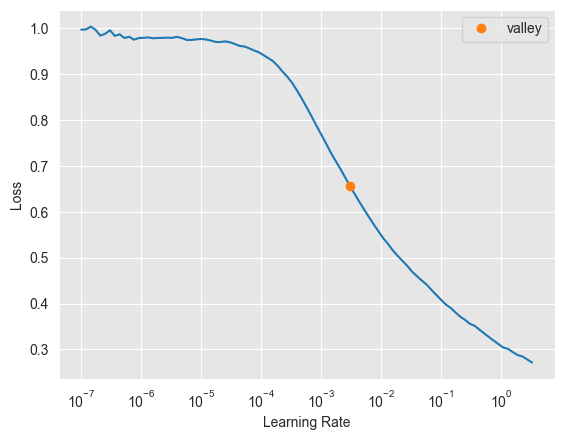

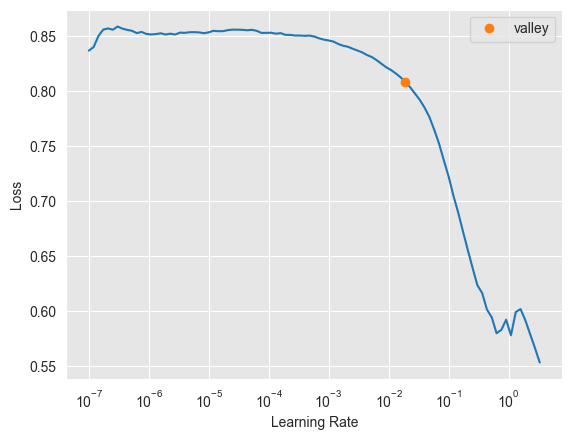

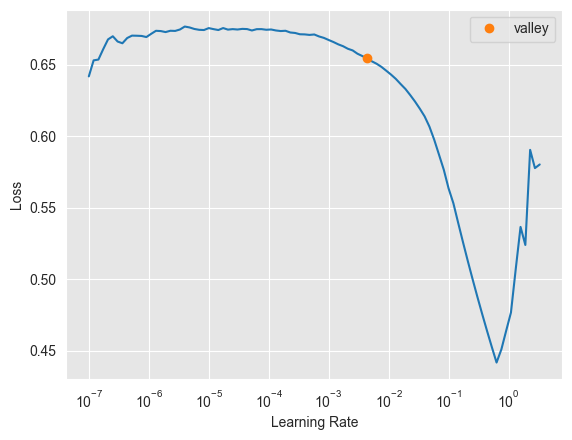

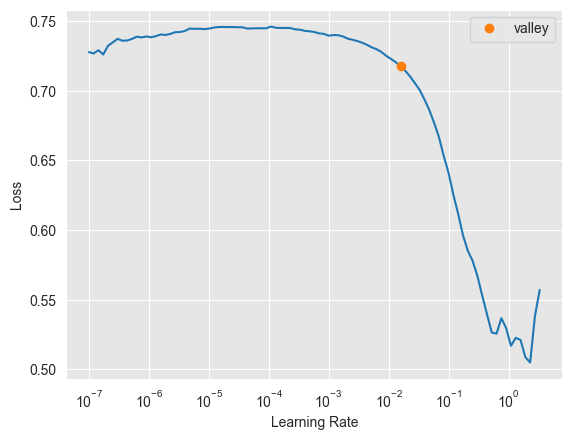

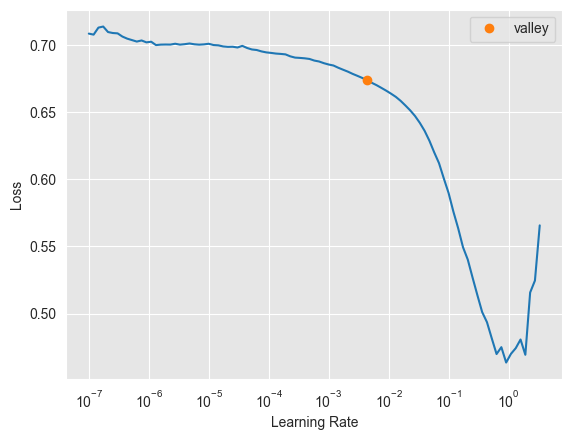

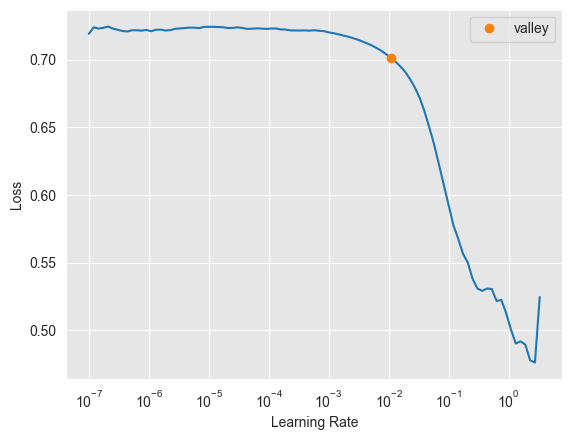

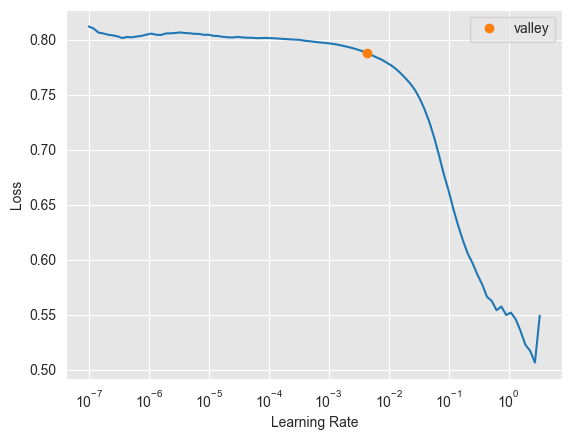

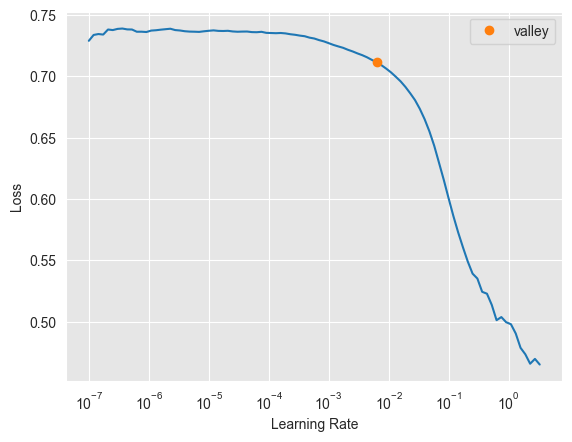

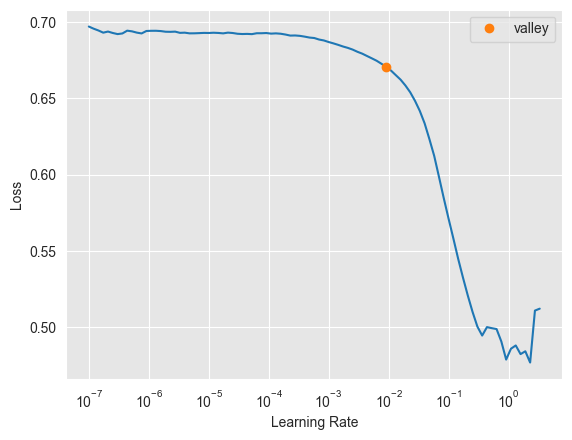

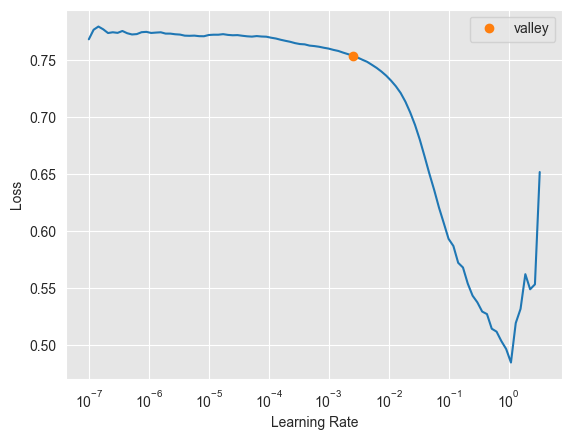

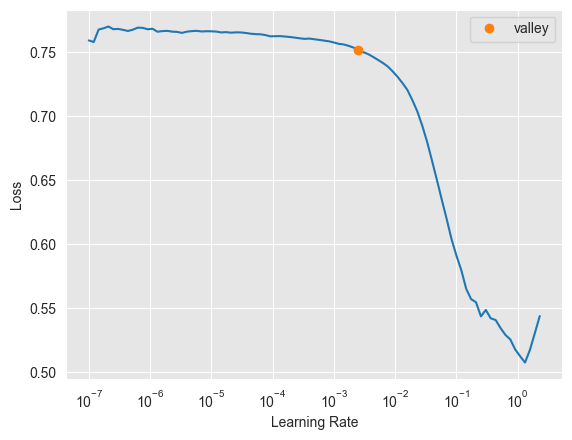

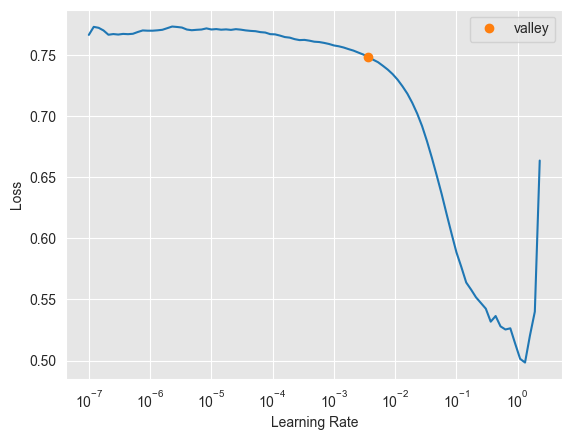

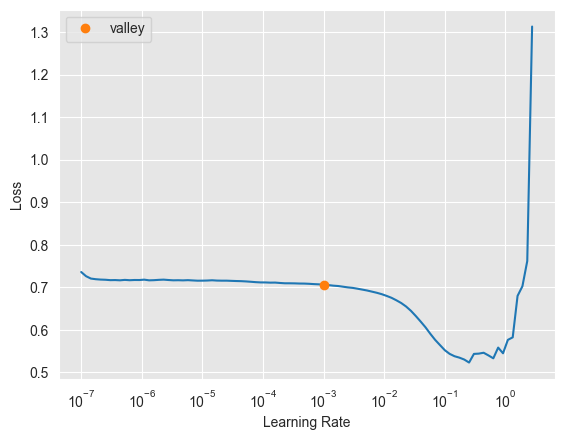

In [23]:
wandb.agent(sweep_id, train, count=60)